# Information Retrieval Assignment



# Import Lib

In [126]:
import pandas as pd
import numpy as np
import re
import math
import warnings
from collections import defaultdict, Counter

# Gensim
from gensim.models import Word2Vec, Doc2Vec, TfidfModel, LsiModel, LdaModel
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from gensim.similarities import SparseMatrixSimilarity, MatrixSimilarity
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric, strip_short, stem_text

# BM25
from rank_bm25 import BM25Okapi, BM25Plus, BM25L

# FAISS
import faiss

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# NLTK
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


# Import the Dataset from Kaggle 

In [9]:
df = pd.read_csv("data/Articles.csv", encoding="latin1")
df.head()

,Article,Date,Heading,NewsType
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


# Show the Total length Row

In [10]:
len(df)

2692

In [78]:
print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"Columns: {df.columns.tolist()}")
print(f"\nNews Types Distribution:")
print(df['NewsType'].value_counts())
print(f"\nSample Articles:")
for i in range(min(3, len(df))):
    print(f"\nDoc {i}: {df.loc[i, 'Article'][:100]}...")

DATASET OVERVIEW
Columns: ['Article', 'Date', 'Heading', 'NewsType']

News Types Distribution:
NewsType
sports      1408
business    1284
Name: count, dtype: int64

Sample Articles:

Doc 0: KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to ...

Doc 1: HONG KONG: Asian markets started 2015 on an upswing in limited trading on Friday, with mainland Chin...

Doc 2: HONG KONG:  Hong Kong shares opened 0.66 percent lower Monday following a tepid lead from Wall Stree...


In [127]:
# Initialize NLTK tools
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_basic(text):
    """Basic preprocessing"""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    return tokens

def preprocess_with_stopwords(text):
    """Preprocessing with stop word removal"""
    tokens = preprocess_basic(text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

def preprocess_with_stemming(text):
    """Preprocessing with stemming"""
    tokens = preprocess_with_stopwords(text)
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

def preprocess_with_lemmatization(text):
    """Preprocessing with lemmatization"""
    tokens = preprocess_with_stopwords(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

def preprocess_gensim(text):
    """Gensim preprocessing"""
    return preprocess_string(str(text))

# Test preprocessing
print("=" * 70)
print("TEXT PREPROCESSING COMPARISON")
print("=" * 70)

sample = df.loc[0, 'Article']
print(f"\nOriginal: {sample[:100]}...")
print(f"\nBasic: {preprocess_basic(sample)[:10]}")
print(f"Without Stopwords: {preprocess_with_stopwords(sample)[:10]}")
print(f"With Stemming: {preprocess_with_stemming(sample)[:10]}")
print(f"With Lemmatization: {preprocess_with_lemmatization(sample)[:10]}")
print(f"Gensim: {preprocess_gensim(sample)[:10]}")

TEXT PREPROCESSING COMPARISON

Original: KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to ...

Basic: ['karachi', 'the', 'sindh', 'government', 'has', 'decided', 'to', 'bring', 'down', 'public']
Without Stopwords: ['karachi', 'sindh', 'government', 'decided', 'bring', 'public', 'transport', 'fares', 'per', 'cent']
With Stemming: ['karachi', 'sindh', 'govern', 'decid', 'bring', 'public', 'transport', 'fare', 'per', 'cent']
With Lemmatization: ['karachi', 'sindh', 'government', 'decided', 'bring', 'public', 'transport', 'fare', 'per', 'cent']
Gensim: ['karachi', 'sindh', 'govern', 'decid', 'bring', 'public', 'transport', 'fare', 'cent', 'massiv']


Text Preprocessing Functions

In [128]:
# Preprocess all documents
corpus_basic = [preprocess_basic(doc) for doc in df['Article']]
corpus_stemmed = [preprocess_with_stemming(doc) for doc in df['Article']]
corpus_lemmatized = [preprocess_with_lemmatization(doc) for doc in df['Article']]
corpus_gensim = [preprocess_gensim(doc) for doc in df['Article']]

print("=" * 70)
print("CORPUS PREPARATION")
print("=" * 70)
print(f"Total Documents: {len(corpus_stemmed)}")
print(f"Sample Document Tokens: {corpus_stemmed[0][:15]}")

# Create Gensim Dictionary and Corpus
dictionary = Dictionary(corpus_stemmed)
print(f"\nGensim Dictionary Size: {len(dictionary)}")

# Filter extremes
dictionary.filter_extremes(no_below=1, no_above=0.9)
print(f"After Filtering: {len(dictionary)}")

# Create Bag of Words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus_stemmed]
print(f"BoW Corpus Size: {len(bow_corpus)}")
print(f"Sample BoW: {bow_corpus[0][:10]}")

CORPUS PREPARATION
Total Documents: 2692
Sample Document Tokens: ['karachi', 'sindh', 'govern', 'decid', 'bring', 'public', 'transport', 'fare', 'per', 'cent', 'due', 'massiv', 'reduct', 'petroleum', 'product']

Gensim Dictionary Size: 36981
After Filtering: 36981
BoW Corpus Size: 2692
Sample BoW: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1)]


# 1. Boolean Retrieval is a classic IR model

 Preprocessing Function

In [11]:
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize (split into words)
    tokens = text.split()
    return tokens

In [80]:

# Test
sample = df.loc[0, 'Article']
print("Original:", sample[:100])
print("Preprocessed:", preprocess_basic(sample)[:15])

Original: KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to 
Preprocessed: ['karachi', 'the', 'sindh', 'government', 'has', 'decided', 'to', 'bring', 'down', 'public', 'transport', 'fares', 'by', 'per', 'cent']


Stop Word Removal

In [81]:
# Common English stop words
STOP_WORDS = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
    'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
    'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
    'should', 'may', 'might', 'must', 'shall', 'can', 'need', 'dare', 'ought',
    'used', 'it', 'its', 'this', 'that', 'these', 'those', 'i', 'you', 'he',
    'she', 'we', 'they', 'what', 'which', 'who', 'whom', 'whose', 'where',
    'when', 'why', 'how', 'all', 'each', 'every', 'both', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
    'same', 'so', 'than', 'too', 'very', 'just', 'also', 'now', 'here',
    'there', 'then', 'once', 'if', 'about', 'into', 'through', 'during',
    'before', 'after', 'above', 'below', 'between', 'under', 'again',
    'further', 'while', 'being', 'having', 'doing', 'their', 'his', 'her'
}

def remove_stopwords(tokens):
    """Remove stop words from token list"""
    return [t for t in tokens if t not in STOP_WORDS]

# Test
tokens = preprocess_basic(sample)
filtered = remove_stopwords(tokens)
print(f"Before stop word removal: {len(tokens)} tokens")
print(f"After stop word removal: {len(filtered)} tokens")
print(f"Sample: {filtered[:15]}")

Before stop word removal: 105 tokens
After stop word removal: 70 tokens
Sample: ['karachi', 'sindh', 'government', 'decided', 'bring', 'down', 'public', 'transport', 'fares', 'per', 'cent', 'due', 'massive', 'reduction', 'petroleum']


Stemming (Porter Stemmer)

In [82]:
class PorterStemmer:
    """Simple Porter Stemmer implementation"""
    
    def __init__(self):
        self.vowels = 'aeiou'
    
    def is_consonant(self, word, i):
        if word[i] in self.vowels:
            return False
        if word[i] == 'y':
            if i == 0:
                return True
            return not self.is_consonant(word, i - 1)
        return True
    
    def measure(self, word):
        """Calculate measure (number of VC sequences)"""
        m = 0
        i = 0
        n = len(word)
        
        while i < n and self.is_consonant(word, i):
            i += 1
        
        while i < n:
            while i < n and not self.is_consonant(word, i):
                i += 1
            if i >= n:
                break
            m += 1
            while i < n and self.is_consonant(word, i):
                i += 1
        
        return m
    
    def stem(self, word):
        """Apply basic stemming rules"""
        if len(word) < 3:
            return word
        
        # Step 1a: Plurals
        if word.endswith('sses'):
            word = word[:-2]
        elif word.endswith('ies'):
            word = word[:-2]
        elif word.endswith('ss'):
            pass
        elif word.endswith('s'):
            word = word[:-1]
        
        # Step 1b: Past tense
        if word.endswith('eed'):
            if self.measure(word[:-3]) > 0:
                word = word[:-1]
        elif word.endswith('ed'):
            if any(c in self.vowels for c in word[:-2]):
                word = word[:-2]
        elif word.endswith('ing'):
            if any(c in self.vowels for c in word[:-3]):
                word = word[:-3]
        
        # Step 2: Common suffixes
        suffixes = [
            ('ational', 'ate'), ('tional', 'tion'), ('enci', 'ence'),
            ('anci', 'ance'), ('izer', 'ize'), ('ation', 'ate'),
            ('ator', 'ate'), ('alism', 'al'), ('iveness', 'ive'),
            ('fulness', 'ful'), ('ousness', 'ous'), ('aliti', 'al'),
            ('iviti', 'ive'), ('biliti', 'ble')
        ]
        
        for suffix, replacement in suffixes:
            if word.endswith(suffix):
                stem = word[:-len(suffix)]
                if self.measure(stem) > 0:
                    word = stem + replacement
                break
        
        return word

stemmer = PorterStemmer()

def stem_tokens(tokens):
    """Apply stemming to token list"""
    return [stemmer.stem(t) for t in tokens]

# Test
test_words = ['running', 'studies', 'happiness', 'connection', 'flying']
print("Stemming Examples:")
for word in test_words:
    print(f"  {word} -> {stemmer.stem(word)}")

Stemming Examples:
  running -> runn
  studies -> studi
  happiness -> happiness
  connection -> connection
  flying -> flying


Complete Text Processing Pipeline

In [83]:
def preprocess_complete(text, remove_stops=True, apply_stemming=True):
    """
    Complete text processing pipeline:
    1. Lowercase
    2. Remove punctuation
    3. Tokenize
    4. Remove stop words (optional)
    5. Apply stemming (optional)
    """
    # Lowercase and remove punctuation
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stop words
    if remove_stops:
        tokens = [t for t in tokens if t not in STOP_WORDS]
    
    # Apply stemming
    if apply_stemming:
        tokens = [stemmer.stem(t) for t in tokens]
    
    return tokens

# Test pipeline
print("=" * 70)
print("COMPLETE TEXT PROCESSING PIPELINE")
print("=" * 70)

sample_text = df.loc[0, 'Article']
print(f"\nOriginal: {sample_text[:100]}...")
print(f"\nBasic tokens: {preprocess_basic(sample_text)[:10]}")
print(f"\nWith stop removal: {preprocess_complete(sample_text, apply_stemming=False)[:10]}")
print(f"\nWith stemming: {preprocess_complete(sample_text)[:10]}")

COMPLETE TEXT PROCESSING PIPELINE

Original: KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to ...

Basic tokens: ['karachi', 'the', 'sindh', 'government', 'has', 'decided', 'to', 'bring', 'down', 'public']

With stop removal: ['karachi', 'sindh', 'government', 'decided', 'bring', 'down', 'public', 'transport', 'fares', 'per']

With stemming: ['karachi', 'sindh', 'government', 'decid', 'bring', 'down', 'public', 'transport', 'fare', 'per']


Build Inverted Index

In [13]:
# Create inverted index
inverted_index = defaultdict(set)

# Using 'Article' column for indexing
for doc_id, row in df.iterrows():
    text = row['Article']  # Changed to your column name
    tokens = preprocess(str(text))
    
    for token in tokens:
        inverted_index[token].add(doc_id)

# Check the index
print("Total terms indexed:", len(inverted_index))
print("Sample terms:", list(inverted_index.keys())[:10])

Total terms indexed: 45504
Sample terms: ['karachi', 'the', 'sindh', 'government', 'has', 'decided', 'to', 'bring', 'down', 'public']


In [84]:
def build_inverted_index(documents, preprocess_func):
    """
    Build an inverted index from documents
    
    Structure: term -> [doc_id1, doc_id2, ...]
    """
    inverted_index = defaultdict(set)
    
    for doc_id, doc in enumerate(documents):
        tokens = preprocess_func(str(doc))
        for token in set(tokens):  # Use set to avoid duplicates
            inverted_index[token].add(doc_id)
    
    # Convert to sorted lists
    inverted_index = {term: sorted(list(docs)) for term, docs in inverted_index.items()}
    
    return inverted_index

# Build index
inverted_index = build_inverted_index(df['Article'], preprocess_complete)

print("=" * 70)
print("INVERTED INDEX")
print("=" * 70)
print(f"Total unique terms: {len(inverted_index)}")
print(f"\nSample entries:")
for term in list(inverted_index.keys())[:10]:
    print(f"  '{term}' -> {inverted_index[term]}")

INVERTED INDEX
Total unique terms: 39518

Sample entries:
  'taxi' -> [0, 44, 158, 1950, 2208, 2538]
  'add' -> [0, 1, 5, 11, 12, 14, 17, 19, 22, 24, 25, 30, 31, 32, 35, 39, 41, 43, 46, 48, 49, 53, 54, 57, 59, 64, 65, 67, 69, 70, 71, 72, 73, 76, 78, 82, 85, 88, 92, 93, 95, 102, 106, 112, 115, 116, 118, 119, 122, 123, 129, 130, 134, 136, 137, 138, 143, 144, 145, 148, 149, 151, 152, 153, 158, 159, 160, 170, 174, 176, 180, 185, 193, 194, 196, 202, 204, 208, 210, 211, 213, 215, 216, 217, 219, 222, 226, 229, 231, 236, 240, 241, 242, 244, 245, 247, 248, 250, 251, 252, 254, 255, 257, 258, 259, 260, 261, 262, 264, 269, 270, 274, 275, 278, 282, 285, 286, 289, 292, 300, 304, 305, 307, 311, 313, 314, 318, 322, 324, 331, 342, 351, 353, 354, 357, 358, 372, 377, 382, 385, 388, 390, 393, 395, 398, 399, 402, 407, 408, 409, 416, 417, 418, 420, 422, 427, 429, 431, 434, 441, 443, 446, 447, 450, 451, 454, 456, 458, 459, 462, 468, 473, 474, 479, 483, 484, 486, 488, 496, 498, 500, 506, 508, 510, 516, 517, 5

Boolean Query Functions

In [14]:
def boolean_and(term1, term2):
    """Returns documents containing BOTH terms"""
    term1 = term1.lower()
    term2 = term2.lower()
    return inverted_index[term1].intersection(inverted_index[term2])

def boolean_or(term1, term2):
    """Returns documents containing EITHER term"""
    term1 = term1.lower()
    term2 = term2.lower()
    return inverted_index[term1].union(inverted_index[term2])

def boolean_not(term):
    """Returns documents NOT containing the term"""
    term = term.lower()
    all_docs = set(df.index)
    return all_docs - inverted_index[term]


Test Boolean Queries

In [15]:
# AND query - documents with "hong" AND "kong"
result_and = boolean_and('hong', 'kong')
print("AND Result (hong AND kong):", result_and)

# OR query - documents with "sindh" OR "york"
result_or = boolean_or('sindh', 'york')
print("OR Result (sindh OR york):", result_or)

# NOT query - documents WITHOUT "hong"
result_not = boolean_not('hong')
print("NOT Result (NOT hong):", result_not)

AND Result (hong AND kong): {1, 2, 3, 11, 525, 17, 533, 24, 539, 2589, 545, 550, 2607, 2610, 53, 566, 1592, 2113, 67, 602, 92, 1636, 106, 112, 116, 119, 123, 129, 648, 137, 158, 685, 185, 1727, 193, 719, 215, 220, 735, 224, 226, 744, 1771, 236, 242, 252, 253, 259, 264, 784, 274, 284, 286, 809, 810, 299, 300, 307, 834, 845, 850, 1365, 342, 1367, 1376, 354, 1378, 1380, 1381, 1382, 879, 884, 373, 380, 1405, 382, 1407, 384, 1408, 387, 901, 913, 918, 2459, 2468, 440, 443, 458, 1003}
OR Result (sindh OR york): {0, 2560, 2562, 3, 4, 5, 8, 2568, 2569, 521, 10, 18, 19, 24, 25, 538, 27, 29, 31, 2591, 2593, 2082, 35, 548, 547, 37, 2599, 40, 557, 558, 2607, 2610, 53, 55, 57, 2619, 572, 61, 62, 2621, 2624, 64, 68, 75, 1612, 2638, 80, 1617, 1618, 2642, 82, 86, 601, 92, 2659, 613, 614, 103, 106, 622, 623, 112, 114, 626, 116, 2677, 117, 630, 119, 120, 634, 123, 127, 1665, 129, 2180, 137, 138, 139, 651, 1685, 158, 674, 165, 677, 679, 681, 684, 176, 177, 178, 1713, 2225, 691, 186, 187, 188, 193, 194, 70

Display Retrieved Documents

In [16]:
def display_results(doc_ids):
    if len(doc_ids) == 0:
        print("No documents found!")
        return None
    return df.loc[list(doc_ids)][['Article', 'Heading']]

# Display AND query results
display_results(result_and)

,Article,Heading
1,HONG KONG: Asian markets started 2015 on an up...,asia stocks up in new year trad
2,HONG KONG: Hong Kong shares opened 0.66 perce...,hong kong stocks open 0.66 percent lower
3,HONG KONG: Asian markets tumbled Tuesday follo...,asian stocks sink euro near nine year
11,HONG KONG: Hong Kong stocks edged up 0.24 perc...,hong kong stocks open 0.24 percent higher
525,strong>HONG KONG: Asian stocks slipped on Tues...,Asia markets slip before BOJ Fed oil sli
...,...,...
2468,"strong>WASHINGTON: The World Bank, in its annu...",Doing Business report Pakistan among 10 most i...
440,strong>SINGAPORE: Oil prices hit their lowest ...,Oil slides to lowest since 2003 as Iran sancti...
443,strong>TOKYO: Battered crude oil prices bounce...,Asia stocks get welcome respite as crude price...
458,strong>TOKYO: Asian shares got off to a rocky ...,Asia stocks slip in holiday thinned trad


In [90]:
class BooleanRetrieval:
    """Boolean Retrieval System"""
    
    def __init__(self, index, num_docs):
        self.index = index
        self.num_docs = num_docs
        self.all_docs = set(range(num_docs))
    
    def get_postings(self, term):
        """Get postings list for a term"""
        term = stemmer.stem(term.lower())
        return set(self.index.get(term, []))
    
    def AND(self, term1, term2):
        """Intersection of two terms"""
        return self.get_postings(term1).intersection(self.get_postings(term2))
    
    def OR(self, term1, term2):
        """Union of two terms"""
        return self.get_postings(term1).union(self.get_postings(term2))
    
    def NOT(self, term):
        """Complement of a term"""
        return self.all_docs - self.get_postings(term)
    
    def AND_NOT(self, term1, term2):
        """term1 AND NOT term2"""
        return self.get_postings(term1) - self.get_postings(term2)
    
    def query(self, query_str):
        """Parse and execute a simple boolean query"""
        query_str = query_str.upper()
        
        if ' AND NOT ' in query_str:
            parts = query_str.split(' AND NOT ')
            return self.AND_NOT(parts[0].strip(), parts[1].strip())
        elif ' AND ' in query_str:
            parts = query_str.split(' AND ')
            result = self.get_postings(parts[0].strip())
            for part in parts[1:]:
                result = result.intersection(self.get_postings(part.strip()))
            return result
        elif ' OR ' in query_str:
            parts = query_str.split(' OR ')
            result = set()
            for part in parts:
                result = result.union(self.get_postings(part.strip()))
            return result
        elif query_str.startswith('NOT '):
            return self.NOT(query_str[4:].strip())
        else:
            return self.get_postings(query_str.strip())

# Create Boolean retrieval system
boolean_ir = BooleanRetrieval(inverted_index, len(df))

# Test queries
print("=" * 70)
print("BOOLEAN RETRIEVAL")
print("=" * 70)

queries = [
    "hong AND kong",
    "stocks OR market",
    "NOT hong",
    "hong AND NOT kong",
    "asia AND stocks AND market"
]

for query in queries:
    result = boolean_ir.query(query)
    print(f"\nQuery: '{query}'")
    print(f"Result: {sorted(result)} ({len(result)} docs)")

BOOLEAN RETRIEVAL

Query: 'hong AND kong'
Result: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 440, 443, 458, 525, 533, 539, 545, 550, 555, 566, 602, 648, 672, 685, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1364, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1592, 1636, 1727, 1771, 2113, 2459, 2468, 2481, 2589, 2607, 2610] (93 docs)

Query: 'stocks OR market'
Result: [1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 17, 18, 19, 24, 25, 27, 30, 32, 35, 37, 39, 40, 41, 48, 53, 55, 57, 59, 60, 61, 62, 64, 66, 67, 70, 74, 76, 78, 80, 82, 84, 85, 86, 88, 90, 92, 93, 94, 95, 97, 100, 101, 103, 104, 105, 106, 108, 109, 112, 113, 114, 116, 117, 119, 120, 123, 127, 129, 130, 133, 137, 138, 139, 142, 143, 145, 146, 151, 153, 155, 158, 160, 169, 170, 173, 176, 181, 185, 188, 193, 196, 197, 198, 199, 201, 202, 

# 2. Ranked Retrieval

Calculate Term Frequency (TF)

In [19]:
# TF for each document
def compute_tf(tokens):
    tf = Counter(tokens)
    total_terms = len(tokens)
    # Normalize TF
    for term in tf:
        tf[term] = tf[term] / total_terms
    return tf

# Store TF for all documents
doc_tf = {}
for doc_id, row in df.iterrows():
    tokens = preprocess(str(row['Article']))
    doc_tf[doc_id] = compute_tf(tokens)

print("TF computed for", len(doc_tf), "documents")

TF computed for 2692 documents


Calculate Document Frequency (DF) & Inverse Document Frequency (IDF)

In [20]:
# Document Frequency
doc_freq = defaultdict(int)

for doc_id, row in df.iterrows():
    tokens = set(preprocess(str(row['Article'])))  # unique terms
    for token in tokens:
        doc_freq[token] += 1

# IDF calculation
N = len(df)  # Total number of documents

def compute_idf(term):
    if doc_freq[term] == 0:
        return 0
    return math.log10(N / doc_freq[term])

# Store IDF for all terms
idf = {term: compute_idf(term) for term in doc_freq}

print("Sample IDF values:")
for term in list(idf.keys())[:5]:
    print(f"  {term}: {idf[term]:.4f}")

Sample IDF values:
  taxi: 2.9530
  parts: 1.8860
  kti: 3.4301
  will: 0.2821
  product: 1.4856


Calculate TF-IDF for All Documents

In [21]:
# TF-IDF for each document
doc_tfidf = {}

for doc_id in doc_tf:
    doc_tfidf[doc_id] = {}
    for term in doc_tf[doc_id]:
        doc_tfidf[doc_id][term] = doc_tf[doc_id][term] * idf.get(term, 0)

print("TF-IDF computed for all documents")

TF-IDF computed for all documents


Calculate TF-IDF

In [93]:
class TFIDF:
    """TF-IDF Calculator"""
    
    def __init__(self, documents, preprocess_func):
        self.documents = documents
        self.preprocess_func = preprocess_func
        self.N = len(documents)
        
        # Build document term frequencies
        self.doc_tf = []
        self.doc_freq = defaultdict(int)
        
        for doc in documents:
            tokens = preprocess_func(str(doc))
            tf = Counter(tokens)
            self.doc_tf.append(tf)
            
            for term in set(tokens):
                self.doc_freq[term] += 1
        
        # Calculate IDF
        self.idf = {}
        for term, df in self.doc_freq.items():
            self.idf[term] = math.log10(self.N / df)
    
    def tf(self, term, doc_id):
        """Raw term frequency"""
        return self.doc_tf[doc_id].get(term, 0)
    
    def tf_log(self, term, doc_id):
        """Log-scaled term frequency: 1 + log(tf)"""
        raw_tf = self.tf(term, doc_id)
        if raw_tf == 0:
            return 0
        return 1 + math.log10(raw_tf)
    
    def tfidf(self, term, doc_id):
        """TF-IDF weight"""
        return self.tf_log(term, doc_id) * self.idf.get(term, 0)
    
    def document_vector(self, doc_id):
        """Get TF-IDF vector for a document"""
        vector = {}
        for term in self.doc_tf[doc_id]:
            vector[term] = self.tfidf(term, doc_id)
        return vector
    
    def query_vector(self, query):
        """Get TF-IDF vector for a query"""
        tokens = self.preprocess_func(query)
        tf = Counter(tokens)
        
        vector = {}
        for term, count in tf.items():
            tf_weight = 1 + math.log10(count) if count > 0 else 0
            vector[term] = tf_weight * self.idf.get(term, 0)
        
        return vector

# Build TF-IDF model
tfidf_model = TFIDF(df['Article'].tolist(), preprocess_complete)

print("=" * 70)
print("TF-IDF MODEL")
print("=" * 70)
print(f"Total documents: {tfidf_model.N}")
print(f"Vocabulary size: {len(tfidf_model.idf)}")

# Show sample IDF values
print("\nSample IDF values:")
for term in list(tfidf_model.idf.keys())[:10]:
    print(f"  '{term}': IDF = {tfidf_model.idf[term]:.4f} (df = {tfidf_model.doc_freq[term]})")

TF-IDF MODEL
Total documents: 2692
Vocabulary size: 39518

Sample IDF values:
  'taxi': IDF = 2.6519 (df = 6)
  'add': IDF = 0.5969 (df = 681)
  'kti': IDF = 3.4301 (df = 1)
  'product': IDF = 1.1971 (df = 171)
  'abide': IDF = 3.1290 (df = 2)
  'commuter': IDF = 2.8280 (df = 4)
  'run': IDF = 0.6937 (df = 545)
  'new': IDF = 0.4081 (df = 1052)
  'applicable': IDF = 2.1290 (df = 20)
  'natural': IDF = 1.5110 (df = 83)


TF-IDF with Sklearn

In [95]:
# Use sklearn for efficient TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=5000
)

# Fit and transform documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Article'])

print("=" * 70)
print("SKLEARN TF-IDF VECTORIZATION")
print("=" * 70)
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Vocabulary Size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"\nSample vocabulary terms: {list(tfidf_vectorizer.vocabulary_.keys())[:15]}")

SKLEARN TF-IDF VECTORIZATION
TF-IDF Matrix Shape: (2692, 5000)
Vocabulary Size: 5000

Sample vocabulary terms: ['karachi', 'sindh', 'government', 'decided', 'bring', 'public', 'transport', 'fares', 'cent', 'massive', 'reduction', 'petroleum', 'product', 'prices', 'federal']


Ranked Search with Sklearn

In [96]:
def ranked_search_sklearn(query, vectorizer, doc_matrix, df, top_k=5):
    """Ranked retrieval using sklearn"""
    
    # Transform query
    query_vec = vectorizer.transform([query])
    
    # Calculate cosine similarity
    similarities = cosine_similarity(query_vec, doc_matrix).flatten()
    
    # Get top-k results
    top_indices = similarities.argsort()[::-1][:top_k]
    
    results = []
    for idx in top_indices:
        results.append({
            'doc_id': idx,
            'score': similarities[idx],
            'heading': df.loc[idx, 'Heading'],
            'article': df.loc[idx, 'Article'][:80] + '...'
        })
    
    return results

# Test
print("=" * 70)
print("RANKED RETRIEVAL (SKLEARN)")
print("=" * 70)

queries = ["hong kong stocks market", "oil prices falling", "asia business economy"]

for query in queries:
    print(f"\n🔍 Query: '{query}'")
    print("-" * 60)
    
    results = ranked_search_sklearn(query, tfidf_vectorizer, tfidf_matrix, df, top_k=5)
    
    for i, res in enumerate(results, 1):
        print(f"\n  Rank {i} | Score: {res['score']:.4f}")
        print(f"  Heading: {res['heading']}")

RANKED RETRIEVAL (SKLEARN)

🔍 Query: 'hong kong stocks market'
------------------------------------------------------------

  Rank 1 | Score: 0.5107
  Heading: hong kong stocks open 0.70 percent higher

  Rank 2 | Score: 0.4766
  Heading: hong kong stocks open 0.24 percent higher

  Rank 3 | Score: 0.4688
  Heading: Hong Kong stocks rise at 

  Rank 4 | Score: 0.4377
  Heading: hong kong stocks open 0.66 percent lower

  Rank 5 | Score: 0.4263
  Heading: Oil plunge fuels run on energy firms as Asia stocks tumb

🔍 Query: 'oil prices falling'
------------------------------------------------------------

  Rank 1 | Score: 0.4181
  Heading: Oil prices stable as market seen bottoming but oversupply linger

  Rank 2 | Score: 0.3659
  Heading: brent crude steady around 50

  Rank 3 | Score: 0.3599
  Heading: furnace oil price rises by about rs 2000 per 

  Rank 4 | Score: 0.3345
  Heading: Oil prices rebound on weaker dollar

  Rank 5 | Score: 0.3025
  Heading: Oil slides to new 11 year low 

Cosine Similarity Function

In [22]:
def cosine_similarity(vec1, vec2):
    # Get all terms
    all_terms = set(vec1.keys()).union(set(vec2.keys()))
    
    # Dot product
    dot_product = sum(vec1.get(term, 0) * vec2.get(term, 0) for term in all_terms)
    
    # Magnitudes
    mag1 = math.sqrt(sum(val**2 for val in vec1.values()))
    mag2 = math.sqrt(sum(val**2 for val in vec2.values()))
    
    if mag1 == 0 or mag2 == 0:
        return 0
    
    return dot_product / (mag1 * mag2)

 Vector Space Model with Cosine Similarity

In [94]:
def cosine_similarity_manual(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    # Get common terms
    common_terms = set(vec1.keys()).union(set(vec2.keys()))
    
    # Dot product
    dot_product = sum(vec1.get(t, 0) * vec2.get(t, 0) for t in common_terms)
    
    # Magnitudes
    mag1 = math.sqrt(sum(v ** 2 for v in vec1.values()))
    mag2 = math.sqrt(sum(v ** 2 for v in vec2.values()))
    
    if mag1 == 0 or mag2 == 0:
        return 0
    
    return dot_product / (mag1 * mag2)

def vsm_search(query, tfidf_model, top_k=5):
    """
    Vector Space Model search using cosine similarity
    """
    query_vec = tfidf_model.query_vector(query)
    
    scores = []
    for doc_id in range(tfidf_model.N):
        doc_vec = tfidf_model.document_vector(doc_id)
        score = cosine_similarity_manual(query_vec, doc_vec)
        scores.append((doc_id, score))
    
    # Sort by score descending
    scores.sort(key=lambda x: x[1], reverse=True)
    
    return scores[:top_k]

# Test VSM search
print("=" * 70)
print("VECTOR SPACE MODEL SEARCH")
print("=" * 70)

test_queries = ["hong kong stocks", "oil prices market", "asian business"]

for query in test_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 50)
    results = vsm_search(query, tfidf_model, top_k=5)
    
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"  Rank {rank}: Doc {doc_id} (Score: {score:.4f})")
        print(f"    Heading: {df.loc[doc_id, 'Heading']}")

VECTOR SPACE MODEL SEARCH

Query: 'hong kong stocks'
--------------------------------------------------
  Rank 1: Doc 11 (Score: 0.4375)
    Heading: hong kong stocks open 0.24 percent higher
  Rank 2: Doc 67 (Score: 0.4243)
    Heading: hong kong stocks open 0.70 percent higher
  Rank 3: Doc 2459 (Score: 0.3319)
    Heading: Hong Kong stocks rise at 
  Rank 4: Doc 2 (Score: 0.3275)
    Heading: hong kong stocks open 0.66 percent lower
  Rank 5: Doc 784 (Score: 0.2933)
    Heading: Hong Kong stocks edge back down at 

Query: 'oil prices market'
--------------------------------------------------
  Rank 1: Doc 155 (Score: 0.1904)
    Heading: pol prices expected to increase in ju
  Rank 2: Doc 327 (Score: 0.1604)
    Heading: pol prices expected to rise in november
  Rank 3: Doc 50 (Score: 0.1426)
    Heading: furnace oil price rises by about rs 2000 per 
  Rank 4: Doc 2639 (Score: 0.1315)
    Heading: Prices of petrol diesel up by one ru
  Rank 5: Doc 131 (Score: 0.1313)
    Heading: no

 Query Processing & Ranking

In [23]:
def ranked_search(query, top_k=5):
    # Preprocess query
    query_tokens = preprocess(query)
    
    # Compute query TF
    query_tf = compute_tf(query_tokens)
    
    # Compute query TF-IDF
    query_tfidf = {}
    for term in query_tf:
        query_tfidf[term] = query_tf[term] * idf.get(term, 0)
    
    # Calculate similarity with all documents
    scores = {}
    for doc_id in doc_tfidf:
        scores[doc_id] = cosine_similarity(query_tfidf, doc_tfidf[doc_id])
    
    # Rank by score (descending)
    ranked_docs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    return ranked_docs[:top_k]

Test Ranked Retrieval

In [24]:
# Example query
query = "hong kong stocks market"

# Get top 5 results
results = ranked_search(query, top_k=5)

print(f"Query: '{query}'\n")
print("Ranked Results:")
print("-" * 50)

for rank, (doc_id, score) in enumerate(results, 1):
    print(f"\nRank {rank} | Score: {score:.4f}")
    print(f"Article: {df.loc[doc_id, 'Article'][:80]}...")
    print(f"Heading: {df.loc[doc_id, 'Heading']}")

Query: 'hong kong stocks market'

Ranked Results:
--------------------------------------------------

Rank 1 | Score: 0.5377
Article: HONG KONG: Hong Kong stocks edged up 0.24 percent in early trade Thursday despit...
Heading: hong kong stocks open 0.24 percent higher

Rank 2 | Score: 0.5141
Article: HONG KONG: Hong Kong stocks rose 0.70 percent in the first few minutes of trade ...
Heading: hong kong stocks open 0.70 percent higher

Rank 3 | Score: 0.4212
Article: strong>HONG KONG: Hong Kong stocks rose in opening exchanges Thursday, tracking ...
Heading: Hong Kong stocks rise at 

Rank 4 | Score: 0.4036
Article: HONG KONG:  Hong Kong shares opened 0.66 percent lower Monday following a tepid ...
Heading: hong kong stocks open 0.66 percent lower

Rank 5 | Score: 0.3067
Article: strong>HONG KONG: Hong Kong stocks fell back again Friday morning after climbing...
Heading: Hong Kong stocks edge back down at 


Display Results as DataFrame

In [25]:
def display_ranked_results(query, top_k=5):
    results = ranked_search(query, top_k)
    
    result_data = []
    for rank, (doc_id, score) in enumerate(results, 1):
        result_data.append({
            'Rank': rank,
            'Score': round(score, 4),
            'Heading': df.loc[doc_id, 'Heading'],
            'Article': df.loc[doc_id, 'Article'][:60] + '...'
        })
    
    return pd.DataFrame(result_data)

# Test with different queries
display_ranked_results("oil prices")

,Rank,Score,Heading,Article
0,1,0.2857,OPEC scrambles agree crucial oil output cu,strong>VIENNA: OPEC members will seek to give ...
1,2,0.2834,oil down in asia on oversupply fear,"Singapore: Oil prices fell in Asia on Monday, ..."
2,3,0.2806,oil prices extend slid,"London: Oil prices slid Monday, extending last..."
3,4,0.2798,Oil prices extend losses in Asia after invento...,strong>Singapore: Crude prices extended losses...
4,5,0.2777,Oil prices stable as market seen bottoming but...,strong>SINGAPORE: Oil prices were stable in ea...


Try More Queries

In [29]:
# Try different queries
print("=" * 60)
display_ranked_results("asian markets business")

# print("=" * 60)
# display_ranked_results("government transport")

,Rank,Score,Heading,Article
0,1,0.1892,Doing Business report Pakistan among 10 most i...,"strong>WASHINGTON: The World Bank, in its annu..."
1,2,0.1629,kse down 1419 points at closing,"KARACHI: Following Asian stock market trend, K..."
2,3,0.1523,Pakistan top emerging economy among South Asia...,strong>ISLAMABAD: Another international rating...
3,4,0.1478,Business leaders discuss reinvention challeng,strong>KARACHI: Business community have discus...
4,5,0.1454,Brexit fear factor sends global stocks spinning,strong>Fears Britain is on the verge of voting...


# 3. Term-Document Incidence Matrix


Get All Unique Terms & Build Vocabulary

In [30]:
# Collect all unique terms from all documents
all_terms = set()

for doc_id, row in df.iterrows():
    tokens = preprocess(str(row['Article']))
    all_terms.update(tokens)

# Convert to sorted list
vocabulary = sorted(list(all_terms))

print(f"Total unique terms: {len(vocabulary)}")
print(f"Sample terms: {vocabulary[:15]}")

Total unique terms: 45504
Sample terms: ['a', 'aa', 'aabar', 'aamer', 'aamir', 'aaoifi', 'aaqib', 'aarif', 'aaron', 'aarons', 'aasia', 'ab', 'aback', 'abandon', 'abandoned']


Create Term-Document Incidence Matrix

In [31]:
# Create empty matrix (rows = terms, columns = documents)
num_terms = len(vocabulary)
num_docs = len(df)

# Initialize matrix with zeros
incidence_matrix = np.zeros((num_terms, num_docs), dtype=int)

# Create term to index mapping
term_to_idx = {term: idx for idx, term in enumerate(vocabulary)}

# Fill the matrix
for doc_id, row in df.iterrows():
    tokens = preprocess(str(row['Article']))
    for token in tokens:
        term_idx = term_to_idx[token]
        incidence_matrix[term_idx][doc_id] = 1

print(f"Matrix Shape: {incidence_matrix.shape}")
print(f"(Rows = {num_terms} terms, Columns = {num_docs} documents)")

Matrix Shape: (45504, 2692)
(Rows = 45504 terms, Columns = 2692 documents)


Display Matrix as DataFrame

In [32]:
# Create DataFrame for better visualization
# Using document IDs as column names
doc_names = [f"Doc{i}" for i in range(num_docs)]

incidence_df = pd.DataFrame(
    incidence_matrix,
    index=vocabulary,
    columns=doc_names
)

# Display sample (first 15 terms × first 5 documents)
print("Term-Document Incidence Matrix (Sample):")
incidence_df.iloc[:15, :5]

Term-Document Incidence Matrix (Sample):


,Doc0,Doc1,Doc2,Doc3,Doc4
a,0,1,1,1,1
aa,0,0,0,0,0
aabar,0,0,0,0,0
aamer,0,0,0,0,0
aamir,0,0,0,0,0
aaoifi,0,0,0,0,0
aaqib,0,0,0,0,0
aarif,0,0,0,0,0
aaron,0,0,0,0,0
aarons,0,0,0,0,0


 Display with Article Headings as Columns

In [33]:
# Use actual headings as column names (truncated)
doc_headings = [heading[:20] + "..." for heading in df['Heading']]

incidence_df_headings = pd.DataFrame(
    incidence_matrix,
    index=vocabulary,
    columns=doc_headings
)

# Display sample
incidence_df_headings.iloc[:15, :5]

,sindh govt decides t...,asia stocks up in ne...,hong kong stocks ope...,asian stocks sink eu...,us oil prices slip b...
a,0,1,1,1,1
aa,0,0,0,0,0
aabar,0,0,0,0,0
aamer,0,0,0,0,0
aamir,0,0,0,0,0
aaoifi,0,0,0,0,0
aaqib,0,0,0,0,0
aarif,0,0,0,0,0
aaron,0,0,0,0,0
aarons,0,0,0,0,0


Query the Matrix - Find Term in Documents

In [34]:
def find_term(term):
    """Find which documents contain a specific term"""
    term = term.lower()
    if term not in term_to_idx:
        print(f"Term '{term}' not found in vocabulary!")
        return []
    
    term_idx = term_to_idx[term]
    doc_ids = np.where(incidence_matrix[term_idx] == 1)[0]
    
    print(f"Term '{term}' appears in {len(doc_ids)} document(s):")
    for doc_id in doc_ids:
        print(f"  - Doc{doc_id}: {df.loc[doc_id, 'Heading']}")
    
    return list(doc_ids)

# Test
find_term('hong')

Term 'hong' appears in 103 document(s):
  - Doc1: asia stocks up in new year trad
  - Doc2: hong kong stocks open 0.66 percent lower
  - Doc3: asian stocks sink euro near nine year 
  - Doc11: hong kong stocks open 0.24 percent higher
  - Doc17: asia stocks mostly higher ahead of ecb meeting
  - Doc24: euro maintains gains asia stocks adv
  - Doc53: asia stocks boosted by greek debt deal 
  - Doc67: hong kong stocks open 0.70 percent higher
  - Doc92: asian markets follow wall st lower after us d
  - Doc106: asian shares rise hong kong at seven year hig
  - Doc112: asia shares mostly up china data disappoi
  - Doc116: asian stocks follow wall street higher
  - Doc119: most asian markets up tokyo at 15 year hig
  - Doc123: asian stocks mostly up after record on wall 
  - Doc129: asian stocks dollar retreat ahead of fed meeting
  - Doc137: asian shares down as wall st tumbles on poor d
  - Doc158: asia stocks extend gains tokyo lifted by weak y
  - Doc185: asia markets mostly lower dolla

[1,
 2,
 3,
 11,
 17,
 24,
 53,
 67,
 92,
 106,
 112,
 116,
 119,
 123,
 129,
 137,
 158,
 185,
 193,
 215,
 220,
 224,
 226,
 236,
 242,
 252,
 253,
 259,
 264,
 274,
 284,
 286,
 299,
 300,
 307,
 342,
 354,
 373,
 380,
 382,
 384,
 387,
 397,
 401,
 429,
 440,
 441,
 443,
 458,
 525,
 533,
 539,
 545,
 550,
 555,
 566,
 602,
 648,
 672,
 685,
 719,
 723,
 735,
 744,
 784,
 806,
 809,
 810,
 834,
 845,
 850,
 879,
 884,
 901,
 913,
 918,
 947,
 1003,
 1192,
 1364,
 1365,
 1367,
 1376,
 1378,
 1380,
 1381,
 1382,
 1405,
 1407,
 1408,
 1411,
 1592,
 1636,
 1727,
 1771,
 2113,
 2459,
 2465,
 2468,
 2481,
 2589,
 2607,
 2610]

Boolean Query Using Incidence Matrix

In [35]:
def boolean_query_and(term1, term2):
    """AND query using incidence matrix"""
    term1, term2 = term1.lower(), term2.lower()
    
    if term1 not in term_to_idx or term2 not in term_to_idx:
        print("One or both terms not found!")
        return []
    
    vec1 = incidence_matrix[term_to_idx[term1]]
    vec2 = incidence_matrix[term_to_idx[term2]]
    
    # AND operation (both must be 1)
    result = vec1 & vec2
    doc_ids = np.where(result == 1)[0]
    
    return list(doc_ids)

def boolean_query_or(term1, term2):
    """OR query using incidence matrix"""
    term1, term2 = term1.lower(), term2.lower()
    
    if term1 not in term_to_idx or term2 not in term_to_idx:
        print("One or both terms not found!")
        return []
    
    vec1 = incidence_matrix[term_to_idx[term1]]
    vec2 = incidence_matrix[term_to_idx[term2]]
    
    # OR operation (either is 1)
    result = vec1 | vec2
    doc_ids = np.where(result == 1)[0]
    
    return list(doc_ids)

def boolean_query_not(term):
    """NOT query using incidence matrix"""
    term = term.lower()
    
    if term not in term_to_idx:
        print("Term not found!")
        return []
    
    vec = incidence_matrix[term_to_idx[term]]
    
    # NOT operation (flip 0s and 1s)
    result = 1 - vec
    doc_ids = np.where(result == 1)[0]
    
    return list(doc_ids)

Test Boolean Queries

In [36]:
# AND Query
print("AND Query: 'hong' AND 'kong'")
result = boolean_query_and('hong', 'kong')
print(f"Documents: {result}\n")

# OR Query
print("OR Query: 'sindh' OR 'york'")
result = boolean_query_or('sindh', 'york')
print(f"Documents: {result}\n")

# NOT Query
print("NOT Query: NOT 'hong'")
result = boolean_query_not('hong')
print(f"Documents: {result}")

AND Query: 'hong' AND 'kong'
Documents: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 440, 443, 458, 525, 533, 539, 545, 550, 566, 602, 648, 685, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1592, 1636, 1727, 1771, 2113, 2459, 2468, 2589, 2607, 2610]

OR Query: 'sindh' OR 'york'
Documents: [0, 3, 4, 5, 8, 10, 18, 19, 24, 25, 27, 29, 31, 35, 37, 40, 53, 55, 57, 61, 62, 64, 68, 75, 80, 82, 86, 92, 103, 106, 112, 114, 116, 117, 119, 120, 123, 127, 129, 137, 138, 139, 158, 165, 176, 177, 178, 186, 187, 188, 193, 194, 198, 201, 203, 207, 209, 210, 215, 216, 217, 218, 224, 226, 233, 236, 242, 243, 244, 246, 252, 254, 257, 258, 259, 262, 264, 267, 268, 269, 272, 286, 289, 295, 297, 299, 305, 307, 342, 346, 347, 351, 373, 375, 380, 382, 384, 387, 388, 38

Display Query Results

In [37]:
def display_query_results(doc_ids):
    """Display documents from query results"""
    if len(doc_ids) == 0:
        print("No documents found!")
        return None
    return df.loc[doc_ids][['Heading', 'Article']]

# Example: Display AND query results
print("Results for 'hong' AND 'kong':")
display_query_results(boolean_query_and('hong', 'kong'))

Results for 'hong' AND 'kong':


,Heading,Article
1,asia stocks up in new year trad,HONG KONG: Asian markets started 2015 on an up...
2,hong kong stocks open 0.66 percent lower,HONG KONG: Hong Kong shares opened 0.66 perce...
3,asian stocks sink euro near nine year,HONG KONG: Asian markets tumbled Tuesday follo...
11,hong kong stocks open 0.24 percent higher,HONG KONG: Hong Kong stocks edged up 0.24 perc...
17,asia stocks mostly higher ahead of ecb meeting,Hong Kong: Asian markets extended their rally ...
...,...,...
2459,Hong Kong stocks rise at,strong>HONG KONG: Hong Kong stocks rose in ope...
2468,Doing Business report Pakistan among 10 most i...,"strong>WASHINGTON: The World Bank, in its annu..."
2589,McDonald sells China operations 208 b,strong>BEIJING: US fast-food giant McDonald´s ...
2607,Global stocks gain as Wall Street eyes Trump i...,NEW YORK: Most major stock indices posted gain...


Display Inverted Index as DataFrame

In [40]:
# Convert to DataFrame for better visualization
index_data = []
for term, postings in sorted(inverted_index.items()):
    index_data.append({
        'Term': term,
        'Document Frequency': len(postings),
        'Postings List': postings
    })

index_df = pd.DataFrame(index_data)
print("Inverted Index:")
index_df.head(15)

Inverted Index:


,Term,Document Frequency,Postings List
0,a,2509,"{1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1..."
1,aa,1,{1469}
2,aabar,1,{659}
3,aamer,9,"{1152, 1446, 1255, 1388, 1390, 1678, 1554, 120..."
4,aamir,4,"{1450, 1033, 1417, 1390}"
5,aaoifi,1,{2448}
6,aaqib,2,"{1889, 1606}"
7,aarif,1,{1185}
8,aaron,40,"{1536, 1538, 1413, 2185, 2570, 1560, 1181, 106..."
9,aarons,1,{1641}


 Inverted Index with Term Frequency

In [41]:
# Inverted Index with TF: term -> [(doc_id, term_freq), ...]
inverted_index_tf = defaultdict(list)

for doc_id, row in df.iterrows():
    tokens = preprocess(str(row['Article']))
    
    # Count term frequency in this document
    term_freq = defaultdict(int)
    for token in tokens:
        term_freq[token] += 1
    
    # Add to inverted index
    for term, freq in term_freq.items():
        inverted_index_tf[term].append((doc_id, freq))

# Sort by doc_id
for term in inverted_index_tf:
    inverted_index_tf[term] = sorted(inverted_index_tf[term], key=lambda x: x[0])

print("Inverted Index with Term Frequency:")
for term in list(inverted_index_tf.keys())[:5]:
    print(f"  '{term}' -> {inverted_index_tf[term]}")

Inverted Index with Term Frequency:
  'karachi' -> [(0, 4), (6, 2), (8, 2), (26, 1), (34, 1), (36, 1), (45, 1), (50, 1), (60, 1), (69, 1), (71, 4), (75, 1), (81, 1), (83, 1), (84, 2), (87, 1), (89, 1), (91, 2), (94, 2), (97, 2), (100, 1), (102, 1), (113, 1), (124, 1), (130, 1), (135, 1), (136, 1), (143, 2), (144, 1), (155, 1), (156, 1), (157, 1), (165, 1), (168, 1), (170, 3), (177, 1), (178, 1), (184, 1), (186, 1), (187, 1), (191, 1), (194, 1), (197, 2), (201, 1), (211, 1), (214, 1), (221, 1), (223, 1), (228, 1), (229, 1), (235, 1), (240, 2), (243, 1), (248, 2), (249, 1), (251, 2), (253, 2), (255, 1), (256, 2), (260, 1), (265, 1), (267, 4), (269, 2), (270, 2), (272, 1), (274, 2), (276, 5), (279, 2), (287, 1), (291, 1), (293, 1), (302, 1), (319, 1), (325, 2), (327, 1), (336, 1), (338, 1), (340, 2), (341, 1), (357, 2), (359, 1), (364, 1), (376, 2), (379, 1), (381, 1), (399, 2), (414, 2), (423, 1), (428, 2), (430, 1), (449, 1), (451, 1), (606, 1), (610, 1), (613, 2), (670, 1), (675, 2), (

Inverted Index with Positions (Positional Index)

In [88]:
print("=" * 70)
print("INVERTED INDEX WITH TERM FREQUENCY")
print("=" * 70)
print(f"Total terms: {len(index_with_tf)}")


INVERTED INDEX WITH TERM FREQUENCY
Total terms: 39518


# Positional Index

In [89]:
def build_positional_index(documents, preprocess_func):
    """
    Build positional index
    
    Structure: term -> {doc_id: [pos1, pos2, ...], ...}
    """
    positional_index = defaultdict(lambda: defaultdict(list))
    
    for doc_id, doc in enumerate(documents):
        tokens = preprocess_func(str(doc))
        for position, token in enumerate(tokens):
            positional_index[token][doc_id].append(position)
    
    # Convert to regular dict
    positional_index = {term: dict(docs) for term, docs in positional_index.items()}
    
    return positional_index

# Build positional index
positional_index = build_positional_index(df['Article'], preprocess_complete)

print("=" * 70)
print("POSITIONAL INDEX")
print("=" * 70)
print(f"Total terms: {len(positional_index)}")
print(f"\nSample entries (term -> {{doc_id: [positions]}}):")
for term in list(positional_index.keys())[:5]:
    print(f"  '{term}':")
    for doc_id, positions in list(positional_index[term].items())[:2]:
        print(f"    Doc {doc_id}: {positions[:10]}{'...' if len(positions) > 10 else ''}")

POSITIONAL INDEX
Total terms: 39518

Sample entries (term -> {doc_id: [positions]}):
  'karachi':
    Doc 0: [0, 32, 48, 62]
    Doc 6: [0, 8]
  'sindh':
    Doc 0: [1]
    Doc 8: [49]
  'government':
    Doc 0: [2, 18, 38]
    Doc 3: [134, 220]
  'decid':
    Doc 0: [3]
    Doc 9: [208]
  'bring':
    Doc 0: [4]
    Doc 13: [25]


In [42]:
# Positional Index: term -> {doc_id: [positions], ...}
positional_index = defaultdict(lambda: defaultdict(list))

for doc_id, row in df.iterrows():
    tokens = preprocess(str(row['Article']))
    
    for position, token in enumerate(tokens):
        positional_index[token][doc_id].append(position)

# Convert to regular dict for display
positional_index = {term: dict(docs) for term, docs in positional_index.items()}

print("Positional Index (with positions):")
for term in list(positional_index.keys())[:5]:
    print(f"\n  '{term}':")
    for doc_id, positions in positional_index[term].items():
        print(f"    Doc{doc_id}: positions {positions}")

Positional Index (with positions):

  'karachi':
    Doc0: positions [0, 47, 71, 92]
    Doc6: positions [0, 11]
    Doc8: positions [0, 37]
    Doc26: positions [0]
    Doc34: positions [0]
    Doc36: positions [126]
    Doc45: positions [0]
    Doc50: positions [0]
    Doc60: positions [0]
    Doc69: positions [57]
    Doc71: positions [18, 98, 115, 125]
    Doc75: positions [0]
    Doc81: positions [0]
    Doc83: positions [94]
    Doc84: positions [0, 4]
    Doc87: positions [0]
    Doc89: positions [0]
    Doc91: positions [0, 16]
    Doc94: positions [0, 15]
    Doc97: positions [0, 37]
    Doc100: positions [83]
    Doc102: positions [0]
    Doc113: positions [0]
    Doc124: positions [0]
    Doc130: positions [0]
    Doc135: positions [0]
    Doc136: positions [0]
    Doc143: positions [0, 8]
    Doc144: positions [0]
    Doc155: positions [0]
    Doc156: positions [0]
    Doc157: positions [0]
    Doc165: positions [0]
    Doc168: positions [0]
    Doc170: positions [290, 494,

Display Postings List for a Term

In [43]:
def show_postings(term):
    """Display postings list for a given term"""
    term = term.lower()
    
    if term not in inverted_index:
        print(f"Term '{term}' not found!")
        return
    
    postings = inverted_index[term]
    
    print(f"Term: '{term}'")
    print(f"Document Frequency (DF): {len(postings)}")
    print(f"Postings List: {postings}")
    print(f"\nDocuments containing '{term}':")
    print("-" * 50)
    
    for doc_id in postings:
        print(f"  Doc{doc_id}: {df.loc[doc_id, 'Heading']}")

# Test
show_postings('hong')

Term: 'hong'
Document Frequency (DF): 103
Postings List: {1, 2, 3, 11, 525, 17, 533, 24, 539, 2589, 545, 550, 555, 2607, 2610, 53, 566, 1592, 2113, 67, 602, 92, 1636, 106, 112, 116, 119, 123, 129, 648, 137, 158, 672, 1192, 685, 185, 1727, 193, 719, 723, 215, 220, 735, 224, 226, 744, 1771, 236, 242, 252, 253, 259, 264, 784, 274, 284, 286, 806, 809, 810, 299, 300, 307, 834, 845, 850, 1364, 1365, 342, 1367, 1376, 354, 1378, 1380, 1381, 1382, 879, 884, 373, 380, 1405, 382, 1407, 384, 1408, 387, 1411, 901, 397, 401, 913, 918, 2459, 2465, 2468, 429, 2481, 947, 440, 441, 443, 458, 1003}

Documents containing 'hong':
--------------------------------------------------
  Doc1: asia stocks up in new year trad
  Doc2: hong kong stocks open 0.66 percent lower
  Doc3: asian stocks sink euro near nine year 
  Doc11: hong kong stocks open 0.24 percent higher
  Doc525: Asia markets slip before BOJ Fed oil sli
  Doc17: asia stocks mostly higher ahead of ecb meeting
  Doc533: Asian stocks slip as oil ski

Display Postings with Term Frequency

In [44]:
def show_postings_with_tf(term):
    """Display postings list with term frequency"""
    term = term.lower()
    
    if term not in inverted_index_tf:
        print(f"Term '{term}' not found!")
        return
    
    postings = inverted_index_tf[term]
    
    print(f"Term: '{term}'")
    print(f"Document Frequency (DF): {len(postings)}")
    print(f"\nPostings List with TF:")
    print("-" * 50)
    print(f"{'Doc ID':<10} {'Term Freq':<12} {'Heading'}")
    print("-" * 50)
    
    for doc_id, tf in postings:
        print(f"{doc_id:<10} {tf:<12} {df.loc[doc_id, 'Heading'][:40]}...")

# Test
show_postings_with_tf('stocks')

Term: 'stocks'
Document Frequency (DF): 183

Postings List with TF:
--------------------------------------------------
Doc ID     Term Freq    Heading
--------------------------------------------------
1          1            asia stocks up in new year trad...
3          1            asian stocks sink euro near nine year ...
4          1            us oil prices slip below 50 a barr...
9          1            oil extends losses as world bank cuts gr...
10         1            tokyo stocks open 0.74 percent lower...
11         1            hong kong stocks open 0.24 percent highe...
18         1            ecc approves export of 1.2 million tons ...
27         1            oil slumps as us crude reserves surge to...
35         1            oil extends gains before us jobs d...
37         1            tokyo stocks open up 1.09 per...
59         1            oil prices extend slid...
61         1            oil prices rebound slightly...
62         2            tokyo stocks open f...
64  

Display Postings with Positions

In [45]:
def show_postings_with_positions(term):
    """Display postings list with positions"""
    term = term.lower()
    
    if term not in positional_index:
        print(f"Term '{term}' not found!")
        return
    
    postings = positional_index[term]
    
    print(f"Term: '{term}'")
    print(f"Document Frequency (DF): {len(postings)}")
    print(f"\nPositional Postings List:")
    print("-" * 60)
    
    for doc_id, positions in postings.items():
        print(f"\n  Doc{doc_id}: {df.loc[doc_id, 'Heading'][:40]}...")
        print(f"    Positions: {positions}")
        print(f"    Frequency: {len(positions)}")

# Test
show_postings_with_positions('market')

Term: 'market'
Document Frequency (DF): 496

Positional Postings List:
------------------------------------------------------------

  Doc3: asian stocks sink euro near nine year ...
    Positions: [477]
    Frequency: 1

  Doc4: us oil prices slip below 50 a barr...
    Positions: [176, 247, 324, 405, 564]
    Frequency: 5

  Doc5: oil hits new 5.5 year lows as saudis def...
    Positions: [67, 99, 169, 205, 232]
    Frequency: 5

  Doc6: bullish kse jumps over 33000 psychologic...
    Positions: [59, 63, 95]
    Frequency: 3

  Doc8: sugar prices drop to rs 49.80 in sind...
    Positions: [2, 57]
    Frequency: 2

  Doc9: oil extends losses as world bank cuts gr...
    Positions: [352]
    Frequency: 1

  Doc12: oil market rebounds on iea repor...
    Positions: [148, 224, 320]
    Frequency: 3

  Doc14: brent crude steady around 50...
    Positions: [279]
    Frequency: 1

  Doc17: asia stocks mostly higher ahead of ecb m...
    Positions: [152]
    Frequency: 1

  Doc19: new saudi 

Query Using Inverted Index (AND Query)

In [46]:
def query_and(term1, term2):
    """AND query using postings lists intersection"""
    term1, term2 = term1.lower(), term2.lower()
    
    if term1 not in inverted_index or term2 not in inverted_index:
        print("One or both terms not found!")
        return []
    
    # Get postings lists
    postings1 = set(inverted_index[term1])
    postings2 = set(inverted_index[term2])
    
    # Intersection
    result = sorted(postings1.intersection(postings2))
    
    print(f"Query: '{term1}' AND '{term2}'")
    print(f"Postings of '{term1}': {inverted_index[term1]}")
    print(f"Postings of '{term2}': {inverted_index[term2]}")
    print(f"Intersection: {result}")
    
    return result

# Test
query_and('hong', 'kong')

Query: 'hong' AND 'kong'
Postings of 'hong': {1, 2, 3, 11, 525, 17, 533, 24, 539, 2589, 545, 550, 555, 2607, 2610, 53, 566, 1592, 2113, 67, 602, 92, 1636, 106, 112, 116, 119, 123, 129, 648, 137, 158, 672, 1192, 685, 185, 1727, 193, 719, 723, 215, 220, 735, 224, 226, 744, 1771, 236, 242, 252, 253, 259, 264, 784, 274, 284, 286, 806, 809, 810, 299, 300, 307, 834, 845, 850, 1364, 1365, 342, 1367, 1376, 354, 1378, 1380, 1381, 1382, 879, 884, 373, 380, 1405, 382, 1407, 384, 1408, 387, 1411, 901, 397, 401, 913, 918, 2459, 2465, 2468, 429, 2481, 947, 440, 441, 443, 458, 1003}
Postings of 'kong': {1, 2, 3, 515, 11, 525, 17, 533, 24, 539, 2589, 545, 550, 553, 2607, 2610, 53, 566, 1592, 2619, 2113, 67, 602, 92, 1636, 106, 112, 116, 119, 123, 129, 648, 137, 649, 158, 685, 688, 185, 1727, 193, 719, 215, 220, 735, 224, 226, 744, 1771, 236, 242, 252, 253, 257, 259, 264, 784, 274, 284, 286, 809, 810, 299, 300, 307, 834, 333, 845, 850, 1365, 342, 1367, 1376, 354, 1378, 1380, 1381, 1382, 879, 884, 373, 

[1,
 2,
 3,
 11,
 17,
 24,
 53,
 67,
 92,
 106,
 112,
 116,
 119,
 123,
 129,
 137,
 158,
 185,
 193,
 215,
 220,
 224,
 226,
 236,
 242,
 252,
 253,
 259,
 264,
 274,
 284,
 286,
 299,
 300,
 307,
 342,
 354,
 373,
 380,
 382,
 384,
 387,
 440,
 443,
 458,
 525,
 533,
 539,
 545,
 550,
 566,
 602,
 648,
 685,
 719,
 735,
 744,
 784,
 809,
 810,
 834,
 845,
 850,
 879,
 884,
 901,
 913,
 918,
 1003,
 1365,
 1367,
 1376,
 1378,
 1380,
 1381,
 1382,
 1405,
 1407,
 1408,
 1592,
 1636,
 1727,
 1771,
 2113,
 2459,
 2468,
 2589,
 2607,
 2610]

Query Using Inverted Index (OR Query)

In [47]:
def query_or(term1, term2):
    """OR query using postings lists union"""
    term1, term2 = term1.lower(), term2.lower()
    
    if term1 not in inverted_index or term2 not in inverted_index:
        print("One or both terms not found!")
        return []
    
    # Get postings lists
    postings1 = set(inverted_index[term1])
    postings2 = set(inverted_index[term2])
    
    # Union
    result = sorted(postings1.union(postings2))
    
    print(f"Query: '{term1}' OR '{term2}'")
    print(f"Postings of '{term1}': {inverted_index[term1]}")
    print(f"Postings of '{term2}': {inverted_index[term2]}")
    print(f"Union: {result}")
    
    return result

# Test
query_or('sindh', 'york')

Query: 'sindh' OR 'york'
Postings of 'sindh': {0, 1665, 2560, 2562, 8, 2568, 2569, 267, 268, 269, 272, 18, 1685, 407, 922, 31, 2591, 289, 929, 548, 165, 295, 684, 177, 178, 186, 187, 1854, 2624, 961, 194, 963, 2500, 709, 201, 75, 1612, 2510, 720, 1618, 2642, 2516, 854, 861, 1375, 737, 2659, 613, 1008, 243, 2677, 888, 1278}
Postings of 'york': {3, 4, 5, 521, 10, 19, 24, 25, 538, 27, 29, 2593, 2082, 35, 547, 37, 2599, 40, 557, 558, 2607, 2610, 53, 55, 57, 2619, 572, 61, 62, 2621, 64, 68, 2638, 80, 1617, 82, 86, 601, 92, 614, 103, 106, 622, 623, 112, 114, 626, 116, 117, 630, 119, 120, 634, 123, 127, 129, 2180, 137, 138, 139, 651, 158, 674, 677, 679, 681, 176, 1713, 2225, 691, 188, 193, 705, 198, 711, 203, 716, 207, 209, 210, 215, 216, 217, 218, 732, 224, 2273, 226, 233, 236, 749, 242, 755, 244, 1780, 246, 758, 252, 254, 2304, 257, 258, 259, 262, 264, 777, 286, 2337, 297, 299, 811, 305, 307, 822, 2361, 1876, 342, 346, 347, 860, 351, 866, 868, 373, 375, 380, 382, 384, 1920, 387, 388, 389, 3

[0,
 3,
 4,
 5,
 8,
 10,
 18,
 19,
 24,
 25,
 27,
 29,
 31,
 35,
 37,
 40,
 53,
 55,
 57,
 61,
 62,
 64,
 68,
 75,
 80,
 82,
 86,
 92,
 103,
 106,
 112,
 114,
 116,
 117,
 119,
 120,
 123,
 127,
 129,
 137,
 138,
 139,
 158,
 165,
 176,
 177,
 178,
 186,
 187,
 188,
 193,
 194,
 198,
 201,
 203,
 207,
 209,
 210,
 215,
 216,
 217,
 218,
 224,
 226,
 233,
 236,
 242,
 243,
 244,
 246,
 252,
 254,
 257,
 258,
 259,
 262,
 264,
 267,
 268,
 269,
 272,
 286,
 289,
 295,
 297,
 299,
 305,
 307,
 342,
 346,
 347,
 351,
 373,
 375,
 380,
 382,
 384,
 387,
 388,
 389,
 392,
 396,
 407,
 445,
 465,
 497,
 507,
 521,
 538,
 547,
 548,
 557,
 558,
 572,
 601,
 613,
 614,
 622,
 623,
 626,
 630,
 634,
 651,
 674,
 677,
 679,
 681,
 684,
 691,
 705,
 709,
 711,
 716,
 720,
 732,
 737,
 749,
 755,
 758,
 777,
 811,
 822,
 854,
 860,
 861,
 866,
 868,
 888,
 922,
 928,
 929,
 934,
 936,
 943,
 952,
 953,
 956,
 961,
 963,
 985,
 989,
 991,
 994,
 997,
 1000,
 1008,
 1278,
 1375,
 1612,
 1617,
 1618,


Phrase Query Using Positional Index

In [48]:
def phrase_query(phrase):
    """Find documents containing exact phrase"""
    terms = preprocess(phrase)
    
    if len(terms) < 2:
        print("Phrase must have at least 2 terms!")
        return []
    
    # Check if all terms exist
    for term in terms:
        if term not in positional_index:
            print(f"Term '{term}' not found!")
            return []
    
    # Get documents containing first term
    candidates = set(positional_index[terms[0]].keys())
    
    # Intersect with documents containing all other terms
    for term in terms[1:]:
        candidates = candidates.intersection(set(positional_index[term].keys()))
    
    # Check for consecutive positions
    result = []
    for doc_id in candidates:
        positions = [positional_index[term][doc_id] for term in terms]
        
        # Check if terms appear consecutively
        for start_pos in positions[0]:
            found = True
            for i, term_positions in enumerate(positions[1:], 1):
                if (start_pos + i) not in term_positions:
                    found = False
                    break
            if found:
                result.append(doc_id)
                break
    
    print(f"Phrase Query: '{phrase}'")
    print(f"Documents found: {result}")
    
    return result

# Test
phrase_query("hong kong")

Phrase Query: 'hong kong'
Documents found: [1, 2, 3, 11, 17, 533, 24, 539, 2589, 545, 550, 2607, 2610, 53, 566, 1592, 2113, 67, 602, 92, 1636, 106, 112, 116, 119, 123, 129, 648, 137, 158, 685, 185, 1727, 193, 719, 215, 220, 735, 224, 226, 744, 1771, 236, 242, 252, 253, 259, 264, 784, 274, 284, 286, 809, 810, 299, 300, 307, 834, 845, 850, 1365, 342, 1367, 1376, 354, 1378, 1380, 1381, 1382, 879, 884, 373, 380, 1405, 382, 1407, 384, 1408, 387, 901, 913, 918, 2459, 2468, 440, 443, 458, 1003]


[1,
 2,
 3,
 11,
 17,
 533,
 24,
 539,
 2589,
 545,
 550,
 2607,
 2610,
 53,
 566,
 1592,
 2113,
 67,
 602,
 92,
 1636,
 106,
 112,
 116,
 119,
 123,
 129,
 648,
 137,
 158,
 685,
 185,
 1727,
 193,
 719,
 215,
 220,
 735,
 224,
 226,
 744,
 1771,
 236,
 242,
 252,
 253,
 259,
 264,
 784,
 274,
 284,
 286,
 809,
 810,
 299,
 300,
 307,
 834,
 845,
 850,
 1365,
 342,
 1367,
 1376,
 354,
 1378,
 1380,
 1381,
 1382,
 879,
 884,
 373,
 380,
 1405,
 382,
 1407,
 384,
 1408,
 387,
 901,
 913,
 918,
 2459,
 2468,
 440,
 443,
 458,
 1003]

Display Full Index Statistics

In [49]:
def index_statistics():
    """Display statistics about the inverted index"""
    
    total_terms = len(inverted_index)
    total_postings = sum(len(postings) for postings in inverted_index.values())
    avg_postings = total_postings / total_terms
    
    # Most frequent terms
    sorted_terms = sorted(inverted_index.items(), key=lambda x: len(x[1]), reverse=True)
    
    print("=" * 50)
    print("INVERTED INDEX STATISTICS")
    print("=" * 50)
    print(f"Total Documents: {len(df)}")
    print(f"Total Unique Terms: {total_terms}")
    print(f"Total Postings: {total_postings}")
    print(f"Average Postings per Term: {avg_postings:.2f}")
    print(f"\nTop 10 Most Frequent Terms:")
    print("-" * 50)
    print(f"{'Term':<20} {'Doc Frequency':<15} {'Postings'}")
    print("-" * 50)
    
    for term, postings in sorted_terms[:10]:
        print(f"{term:<20} {len(postings):<15} {postings}")

index_statistics()

INVERTED INDEX STATISTICS
Total Documents: 2692
Total Unique Terms: 45504
Total Postings: 447006
Average Postings per Term: 9.82

Top 10 Most Frequent Terms:
--------------------------------------------------
Term                 Doc Frequency   Postings
--------------------------------------------------
the                  2688            {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 

# 3. Algorithm for Intersection of Postings Lists

 Build Inverted Index with Sorted Postings

In [52]:
# Build inverted index with SORTED postings lists
inverted_index = defaultdict(list)

for doc_id, row in df.iterrows():
    tokens = preprocess(str(row['Article']))
    unique_tokens = set(tokens)
    
    for token in unique_tokens:
        inverted_index[token].append(doc_id)

# Sort all postings lists (IMPORTANT for merge algorithm)
for term in inverted_index:
    inverted_index[term] = sorted(inverted_index[term])

print(f"Total terms: {len(inverted_index)}")
print("\nSample postings (sorted):")
for term in list(inverted_index.keys())[:3]:
    print(f"  '{term}' -> {inverted_index[term]}")


Total terms: 45504

Sample postings (sorted):
  'taxi' -> [0, 158, 1950]
  'parts' -> [0, 13, 88, 167, 267, 444, 445, 457, 477, 531, 607, 673, 680, 686, 704, 715, 729, 761, 967, 976, 1321, 1447, 1867, 2276, 2329, 2435, 2499, 2530, 2540, 2587, 2594, 2621, 2628, 2668, 2686]
  'kti' -> [0]


In [91]:
def intersect_postings(p1, p2, verbose=False):
    """
    Efficient intersection of two sorted postings lists
    Time Complexity: O(n + m)
    """
    result = []
    i, j = 0, 0
    comparisons = 0
    
    while i < len(p1) and j < len(p2):
        comparisons += 1
        if p1[i] == p2[j]:
            result.append(p1[i])
            i += 1
            j += 1
        elif p1[i] < p2[j]:
            i += 1
        else:
            j += 1
    
    if verbose:
        print(f"Comparisons: {comparisons}")
    
    return result

# Test
p1 = inverted_index.get(stemmer.stem('hong'), [])
p2 = inverted_index.get(stemmer.stem('kong'), [])

print("=" * 70)
print("POSTINGS LIST INTERSECTION")
print("=" * 70)
print(f"Postings for 'hong': {p1}")
print(f"Postings for 'kong': {p2}")
result = intersect_postings(p1, p2, verbose=True)
print(f"Intersection: {result}")

POSTINGS LIST INTERSECTION
Postings for 'hong': [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 397, 401, 429, 440, 441, 443, 458, 525, 533, 539, 545, 550, 555, 566, 602, 648, 672, 685, 719, 723, 735, 744, 784, 806, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 947, 1003, 1192, 1364, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1411, 1592, 1636, 1727, 1771, 2113, 2459, 2465, 2468, 2481, 2589, 2607, 2610]
Postings for 'kong': [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 198, 215, 220, 224, 226, 236, 242, 252, 253, 257, 259, 264, 274, 284, 286, 299, 300, 307, 333, 342, 354, 373, 380, 382, 384, 387, 396, 440, 443, 454, 458, 515, 525, 533, 539, 545, 550, 553, 555, 566, 602, 648, 649, 672, 685, 688, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1364, 1365,

Algorithm 1 - Simple Set Intersection

In [53]:
def intersect_simple(term1, term2):
    """
    Simple intersection using Python sets
    Time Complexity: O(n + m) average
    """
    postings1 = set(inverted_index.get(term1.lower(), []))
    postings2 = set(inverted_index.get(term2.lower(), []))
    
    result = postings1 & postings2  # Set intersection
    
    return sorted(list(result))

# Test
print("Simple Set Intersection:")
print(f"Result: {intersect_simple('hong', 'kong')}")

Simple Set Intersection:
Result: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 440, 443, 458, 525, 533, 539, 545, 550, 566, 602, 648, 685, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1592, 1636, 1727, 1771, 2113, 2459, 2468, 2589, 2607, 2610]


Linear Merge Algorithm (No Skip Pointers)

In [54]:
def intersect_no_skip(p1, p2, verbose=True):
    """
    Linear Merge Intersection WITHOUT Skip Pointers
    
    Algorithm:
    - Use two pointers (i, j) starting at beginning
    - Compare elements, advance smaller pointer
    - If equal, add to result and advance both
    
    Time Complexity: O(n + m)
    """
    result = []
    i, j = 0, 0
    comparisons = 0
    
    if verbose:
        print("=" * 60)
        print("INTERSECTION WITHOUT SKIP POINTERS (Linear Merge)")
        print("=" * 60)
        print(f"Postings List 1: {p1}")
        print(f"Postings List 2: {p2}")
        print("-" * 60)
        print(f"{'Step':<6} {'i':<4} {'j':<4} {'p1[i]':<8} {'p2[j]':<8} {'Action':<20} {'Result'}")
        print("-" * 60)
    
    step = 1
    while i < len(p1) and j < len(p2):
        comparisons += 1
        
        if p1[i] == p2[j]:
            result.append(p1[i])
            action = f"MATCH! Add {p1[i]}"
            if verbose:
                print(f"{step:<6} {i:<4} {j:<4} {p1[i]:<8} {p2[j]:<8} {action:<20} {result}")
            i += 1
            j += 1
        elif p1[i] < p2[j]:
            action = "Advance i"
            if verbose:
                print(f"{step:<6} {i:<4} {j:<4} {p1[i]:<8} {p2[j]:<8} {action:<20} {result}")
            i += 1
        else:
            action = "Advance j"
            if verbose:
                print(f"{step:<6} {i:<4} {j:<4} {p1[i]:<8} {p2[j]:<8} {action:<20} {result}")
            j += 1
        step += 1
    
    if verbose:
        print("-" * 60)
        print(f"Total Comparisons: {comparisons}")
        print(f"Final Result: {result}")
    
    return result, comparisons

# Test
p1 = inverted_index.get('hong', [])
p2 = inverted_index.get('kong', [])
intersect_no_skip(p1, p2)

INTERSECTION WITHOUT SKIP POINTERS (Linear Merge)
Postings List 1: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 397, 401, 429, 440, 441, 443, 458, 525, 533, 539, 545, 550, 555, 566, 602, 648, 672, 685, 719, 723, 735, 744, 784, 806, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 947, 1003, 1192, 1364, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1411, 1592, 1636, 1727, 1771, 2113, 2459, 2465, 2468, 2481, 2589, 2607, 2610]
Postings List 2: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 257, 259, 264, 274, 284, 286, 299, 300, 307, 333, 342, 354, 373, 380, 382, 384, 387, 396, 440, 443, 454, 458, 515, 525, 533, 539, 545, 550, 553, 566, 602, 648, 649, 685, 688, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1365, 1367,

([1,
  2,
  3,
  11,
  17,
  24,
  53,
  67,
  92,
  106,
  112,
  116,
  119,
  123,
  129,
  137,
  158,
  185,
  193,
  215,
  220,
  224,
  226,
  236,
  242,
  252,
  253,
  259,
  264,
  274,
  284,
  286,
  299,
  300,
  307,
  342,
  354,
  373,
  380,
  382,
  384,
  387,
  440,
  443,
  458,
  525,
  533,
  539,
  545,
  550,
  566,
  602,
  648,
  685,
  719,
  735,
  744,
  784,
  809,
  810,
  834,
  845,
  850,
  879,
  884,
  901,
  913,
  918,
  1003,
  1365,
  1367,
  1376,
  1378,
  1380,
  1381,
  1382,
  1405,
  1407,
  1408,
  1592,
  1636,
  1727,
  1771,
  2113,
  2459,
  2468,
  2589,
  2607,
  2610],
 112)

Simple Version (No Skip Pointers)

In [55]:
def intersect_linear(p1, p2):
    """
    Clean version - Linear Merge WITHOUT Skip Pointers
    """
    result = []
    i, j = 0, 0
    
    while i < len(p1) and j < len(p2):
        if p1[i] == p2[j]:
            result.append(p1[i])
            i += 1
            j += 1
        elif p1[i] < p2[j]:
            i += 1
        else:
            j += 1
    
    return result

# Test
print("Linear Merge Result:", intersect_linear(p1, p2))

Linear Merge Result: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 440, 443, 458, 525, 533, 539, 545, 550, 566, 602, 648, 685, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1592, 1636, 1727, 1771, 2113, 2459, 2468, 2589, 2607, 2610]


PART 2: WITH SKIP POINTERS

 Create Skip Pointers

In [56]:
def build_skip_pointers(postings):
    """
    Build skip pointers for a postings list
    
    Skip Distance = sqrt(length of list)
    Skip pointer at position i points to position i + skip_distance
    """
    n = len(postings)
    skip_distance = int(math.sqrt(n))
    
    if skip_distance == 0:
        skip_distance = 1
    
    # Create skip pointers dictionary
    # Key: index, Value: (skip_to_index, skip_to_value)
    skip_pointers = {}
    
    for i in range(0, n, skip_distance):
        skip_to = i + skip_distance
        if skip_to < n:
            skip_pointers[i] = {
                'skip_to_index': skip_to,
                'skip_to_value': postings[skip_to]
            }
    
    return skip_distance, skip_pointers

# Display skip pointers for a term
def show_skip_pointers(term):
    """Visualize skip pointers for a term's postings list"""
    postings = inverted_index.get(term.lower(), [])
    skip_dist, skip_ptrs = build_skip_pointers(postings)
    
    print(f"Term: '{term}'")
    print(f"Postings List: {postings}")
    print(f"Length: {len(postings)}")
    print(f"Skip Distance: {skip_dist} (√{len(postings)} ≈ {skip_dist})")
    print(f"\nSkip Pointers:")
    print("-" * 50)
    
    for idx, skip_info in skip_ptrs.items():
        print(f"  Index {idx} (value={postings[idx]}) --skip--> Index {skip_info['skip_to_index']} (value={skip_info['skip_to_value']})")
    
    # Visual representation
    print(f"\nVisual:")
    print("  Postings:", end=" ")
    for i, doc in enumerate(postings):
        print(f"[{doc}]", end="")
        if i in skip_ptrs:
            print(f"--skip-->", end="")
        else:
            print("-", end="")
    print()
    
    return skip_dist, skip_ptrs

show_skip_pointers('hong')

Term: 'hong'
Postings List: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 397, 401, 429, 440, 441, 443, 458, 525, 533, 539, 545, 550, 555, 566, 602, 648, 672, 685, 719, 723, 735, 744, 784, 806, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 947, 1003, 1192, 1364, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1411, 1592, 1636, 1727, 1771, 2113, 2459, 2465, 2468, 2481, 2589, 2607, 2610]
Length: 103
Skip Distance: 10 (√103 ≈ 10)

Skip Pointers:
--------------------------------------------------
  Index 0 (value=1) --skip--> Index 10 (value=112)
  Index 10 (value=112) --skip--> Index 20 (value=220)
  Index 20 (value=220) --skip--> Index 30 (value=284)
  Index 30 (value=284) --skip--> Index 40 (value=384)
  Index 40 (value=384) --skip--> Index 50 (value=533)
  Index 50 (value=533) --skip--> Index 60 (value=719)
  Index 60 (

(10,
 {0: {'skip_to_index': 10, 'skip_to_value': 112},
  10: {'skip_to_index': 20, 'skip_to_value': 220},
  20: {'skip_to_index': 30, 'skip_to_value': 284},
  30: {'skip_to_index': 40, 'skip_to_value': 384},
  40: {'skip_to_index': 50, 'skip_to_value': 533},
  50: {'skip_to_index': 60, 'skip_to_value': 719},
  60: {'skip_to_index': 70, 'skip_to_value': 850},
  70: {'skip_to_index': 80, 'skip_to_value': 1365},
  80: {'skip_to_index': 90, 'skip_to_value': 1411},
  90: {'skip_to_index': 100, 'skip_to_value': 2589}})

Simple Version (With Skip Pointers)

In [57]:
def intersect_skip(p1, p2):
    """
    Clean version - Intersection WITH Skip Pointers
    """
    skip_dist1, skip_ptrs1 = build_skip_pointers(p1)
    skip_dist2, skip_ptrs2 = build_skip_pointers(p2)
    
    result = []
    i, j = 0, 0
    
    while i < len(p1) and j < len(p2):
        if p1[i] == p2[j]:
            result.append(p1[i])
            i += 1
            j += 1
        elif p1[i] < p2[j]:
            # Try skip
            if i in skip_ptrs1 and skip_ptrs1[i]['skip_to_value'] <= p2[j]:
                i = skip_ptrs1[i]['skip_to_index']
            else:
                i += 1
        else:
            # Try skip
            if j in skip_ptrs2 and skip_ptrs2[j]['skip_to_value'] <= p1[i]:
                j = skip_ptrs2[j]['skip_to_index']
            else:
                j += 1
    
    return result

# Test
print("Skip Pointer Result:", intersect_skip(p1, p2))

Skip Pointer Result: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 440, 443, 458, 525, 533, 539, 545, 550, 566, 602, 648, 685, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1592, 1636, 1727, 1771, 2113, 2459, 2468, 2589, 2607, 2610]


Side-by-Side Comparison

In [60]:
def search_query(term1, term2, use_skip=True):
    """
    Execute AND query with or without skip pointers
    """
    p1 = inverted_index.get(term1.lower(), [])
    p2 = inverted_index.get(term2.lower(), [])
    
    if use_skip:
        result = intersect_skip(p1, p2)
        method = "With Skip Pointers"
    else:
        result = intersect_linear(p1, p2)
        method = "Without Skip Pointers"
    
    print(f"Query: '{term1}' AND '{term2}'")
    print(f"Method: {method}")
    print(f"Result: {result}")
    print(f"\nMatching Documents:")
    print("-" * 50)
    
    for doc_id in result:
        print(f"  Doc {doc_id}: {df.loc[doc_id, 'Heading']}")
    
    return result

# Test both methods
print("=" * 60)
search_query('hong', 'kong', use_skip=False)
print("\n" + "=" * 60)
search_query('hong', 'kong', use_skip=True)

Query: 'hong' AND 'kong'
Method: Without Skip Pointers
Result: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 440, 443, 458, 525, 533, 539, 545, 550, 566, 602, 648, 685, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1592, 1636, 1727, 1771, 2113, 2459, 2468, 2589, 2607, 2610]

Matching Documents:
--------------------------------------------------
  Doc 1: asia stocks up in new year trad
  Doc 2: hong kong stocks open 0.66 percent lower
  Doc 3: asian stocks sink euro near nine year 
  Doc 11: hong kong stocks open 0.24 percent higher
  Doc 17: asia stocks mostly higher ahead of ecb meeting
  Doc 24: euro maintains gains asia stocks adv
  Doc 53: asia stocks boosted by greek debt deal 
  Doc 67: hong kong stocks open 0.70 percent higher
  Doc 92: asi

[1,
 2,
 3,
 11,
 17,
 24,
 53,
 67,
 92,
 106,
 112,
 116,
 119,
 123,
 129,
 137,
 158,
 185,
 193,
 215,
 220,
 224,
 226,
 236,
 242,
 252,
 253,
 259,
 264,
 274,
 284,
 286,
 299,
 300,
 307,
 342,
 354,
 373,
 380,
 382,
 384,
 387,
 440,
 443,
 458,
 525,
 533,
 539,
 545,
 550,
 566,
 602,
 648,
 685,
 719,
 735,
 744,
 784,
 809,
 810,
 834,
 845,
 850,
 879,
 884,
 901,
 913,
 918,
 1003,
 1365,
 1367,
 1376,
 1378,
 1380,
 1381,
 1382,
 1405,
 1407,
 1408,
 1592,
 1636,
 1727,
 1771,
 2113,
 2459,
 2468,
 2589,
 2607,
 2610]

# 5. PHRASE QUERY

In [62]:
def phrase_query_two_terms(term1, term2, verbose=True):
    """
    Find documents containing 'term1 term2' as exact phrase
    
    Algorithm:
    1. Get positional postings for both terms
    2. Find documents containing both terms
    3. For each common document, check if term2 appears at position (term1_pos + 1)
    """
    term1, term2 = term1.lower(), term2.lower()
    
    if verbose:
        print("=" * 70)
        print(f"PHRASE QUERY: '{term1} {term2}'")
        print("=" * 70)
    
    # Check if terms exist
    if term1 not in positional_index:
        print(f"Term '{term1}' not found!")
        return []
    if term2 not in positional_index:
        print(f"Term '{term2}' not found!")
        return []
    
    postings1 = positional_index[term1]
    postings2 = positional_index[term2]
    
    if verbose:
        print(f"\nPositional Postings for '{term1}':")
        for doc_id, pos in postings1.items():
            print(f"  Doc {doc_id}: {pos}")
        
        print(f"\nPositional Postings for '{term2}':")
        for doc_id, pos in postings2.items():
            print(f"  Doc {doc_id}: {pos}")
    
    # Find common documents
    common_docs = set(postings1.keys()).intersection(set(postings2.keys()))
    
    if verbose:
        print(f"\nDocuments containing both terms: {common_docs}")
        print("-" * 70)
    
    # Check phrase condition
    result = []
    
    for doc_id in common_docs:
        positions1 = postings1[doc_id]
        positions2 = postings2[doc_id]
        
        if verbose:
            print(f"\nChecking Doc {doc_id}:")
            print(f"  '{term1}' positions: {positions1}")
            print(f"  '{term2}' positions: {positions2}")
        
        # For each position of term1, check if term2 is at position+1
        phrase_found = False
        phrase_positions = []
        
        for pos1 in positions1:
            if (pos1 + 1) in positions2:
                phrase_found = True
                phrase_positions.append((pos1, pos1 + 1))
                if verbose:
                    print(f"  ✓ PHRASE FOUND at positions ({pos1}, {pos1 + 1})")
        
        if phrase_found:
            result.append({
                'doc_id': doc_id,
                'positions': phrase_positions
            })
        else:
            if verbose:
                print(f"  ✗ No phrase match")
    
    if verbose:
        print("\n" + "=" * 70)
        print(f"RESULT: {len(result)} document(s) contain the phrase '{term1} {term2}'")
        print("=" * 70)
    
    return result

# Test
phrase_query_two_terms('hong', 'kong')

PHRASE QUERY: 'hong kong'

Positional Postings for 'hong':
  Doc 1: [0, 19, 92]
  Doc 2: [0, 2]
  Doc 3: [0, 67]
  Doc 11: [0, 2]
  Doc 17: [0, 55]
  Doc 24: [0, 84]
  Doc 53: [0, 68]
  Doc 67: [0, 2]
  Doc 92: [0, 106]
  Doc 106: [0, 14, 87]
  Doc 112: [0, 8, 156, 166, 241]
  Doc 116: [0, 30]
  Doc 119: [0, 61]
  Doc 123: [0]
  Doc 129: [0, 89]
  Doc 137: [94]
  Doc 158: [0]
  Doc 185: [0, 67]
  Doc 193: [0, 90, 400, 579]
  Doc 215: [40]
  Doc 220: [0, 65]
  Doc 224: [0, 109]
  Doc 226: [0, 88]
  Doc 236: [0]
  Doc 242: [0, 352]
  Doc 252: [0, 89]
  Doc 253: [59]
  Doc 259: [0, 100]
  Doc 264: [0, 59]
  Doc 274: [100, 153]
  Doc 284: [0, 44]
  Doc 286: [0, 18, 257]
  Doc 299: [0, 300]
  Doc 300: [0, 155, 190]
  Doc 307: [0, 290]
  Doc 342: [198]
  Doc 354: [0, 181]
  Doc 373: [0, 455]
  Doc 380: [0, 214, 391]
  Doc 382: [0, 134, 262]
  Doc 384: [492]
  Doc 387: [0, 156, 217, 276, 359, 367, 379]
  Doc 397: [157]
  Doc 401: [172]
  Doc 429: [106]
  Doc 440: [450]
  Doc 441: [124]
  Doc 

[{'doc_id': 1, 'positions': [(0, 1), (19, 20), (92, 93)]},
 {'doc_id': 2, 'positions': [(0, 1), (2, 3)]},
 {'doc_id': 3, 'positions': [(0, 1), (67, 68)]},
 {'doc_id': 11, 'positions': [(0, 1), (2, 3)]},
 {'doc_id': 17, 'positions': [(0, 1), (55, 56)]},
 {'doc_id': 533, 'positions': [(166, 167)]},
 {'doc_id': 24, 'positions': [(0, 1), (84, 85)]},
 {'doc_id': 539, 'positions': [(144, 145)]},
 {'doc_id': 2589, 'positions': [(15, 16), (64, 65), (174, 175), (201, 202)]},
 {'doc_id': 545, 'positions': [(14, 15)]},
 {'doc_id': 550, 'positions': [(163, 164), (180, 181)]},
 {'doc_id': 2607, 'positions': [(275, 276)]},
 {'doc_id': 2610, 'positions': [(360, 361)]},
 {'doc_id': 53, 'positions': [(0, 1), (68, 69)]},
 {'doc_id': 566, 'positions': [(3, 4), (72, 73), (88, 89), (271, 272)]},
 {'doc_id': 1592, 'positions': [(180, 181)]},
 {'doc_id': 2113, 'positions': [(95, 96)]},
 {'doc_id': 67, 'positions': [(0, 1), (2, 3)]},
 {'doc_id': 602, 'positions': [(111, 112)]},
 {'doc_id': 92, 'positions': [(

In [92]:
def phrase_query(phrase, positional_idx, preprocess_func):
    """
    Find documents containing exact phrase
    """
    terms = preprocess_func(phrase)
    
    if len(terms) < 2:
        return list(positional_idx.get(terms[0], {}).keys()) if terms else []
    
    # Check all terms exist
    for term in terms:
        if term not in positional_idx:
            return []
    
    # Get postings for all terms
    all_postings = [positional_idx[term] for term in terms]
    
    # Find common documents
    common_docs = set(all_postings[0].keys())
    for postings in all_postings[1:]:
        common_docs = common_docs.intersection(set(postings.keys()))
    
    # Check consecutive positions
    result = []
    for doc_id in common_docs:
        first_positions = all_postings[0][doc_id]
        
        for start_pos in first_positions:
            is_phrase = True
            for i in range(1, len(terms)):
                if (start_pos + i) not in all_postings[i][doc_id]:
                    is_phrase = False
                    break
            
            if is_phrase:
                result.append(doc_id)
                break
    
    return result

# Test
print("=" * 70)
print("PHRASE QUERY")
print("=" * 70)

test_phrases = ["hong kong", "stock market", "oil prices"]
for phrase in test_phrases:
    results = phrase_query(phrase, positional_index, preprocess_complete)
    print(f"\nPhrase: '{phrase}'")
    print(f"Documents: {results}")

PHRASE QUERY

Phrase: 'hong kong'
Documents: [1, 2, 3, 11, 17, 533, 24, 539, 2589, 545, 550, 555, 2607, 2610, 53, 566, 1592, 2113, 67, 602, 92, 1636, 106, 112, 116, 119, 123, 129, 648, 137, 158, 672, 685, 185, 1727, 193, 719, 215, 220, 735, 224, 226, 744, 1771, 236, 242, 252, 253, 259, 264, 784, 274, 284, 286, 809, 810, 299, 300, 307, 834, 845, 850, 1364, 1365, 342, 1367, 1376, 354, 1378, 1380, 1381, 1382, 879, 884, 373, 380, 1405, 382, 1407, 384, 1408, 387, 901, 913, 918, 2459, 2468, 2481, 440, 443, 458, 1003]

Phrase: 'stock market'
Documents: [6, 2580, 533, 534, 2600, 553, 2612, 566, 84, 116, 137, 658, 677, 170, 702, 193, 198, 199, 204, 719, 723, 213, 726, 217, 731, 745, 757, 758, 251, 253, 255, 259, 772, 264, 274, 796, 286, 802, 299, 300, 354, 357, 375, 382, 384, 2465, 422, 429, 2487, 440, 441, 443, 2489, 2490, 2514, 470, 2524, 486, 1014, 2555]

Phrase: 'oil prices'
Documents: [1, 4, 5, 9, 10, 12, 14, 23, 25, 27, 30, 32, 33, 35, 37, 38, 39, 41, 48, 49, 50, 55, 57, 59, 61, 64, 66, 6

# 5.  Biword Indexing

Generate Biwords from Text

In [63]:
def generate_biwords(tokens):
    """
    Generate biwords (consecutive word pairs) from a list of tokens
    
    Example: ['hong', 'kong', 'stocks'] -> ['hong kong', 'kong stocks']
    """
    biwords = []
    for i in range(len(tokens) - 1):
        biword = tokens[i] + " " + tokens[i + 1]
        biwords.append(biword)
    return biwords

# Test
sample_tokens = ['hong', 'kong', 'stocks', 'market', 'rise']
print("Tokens:", sample_tokens)
print("Biwords:", generate_biwords(sample_tokens))

Tokens: ['hong', 'kong', 'stocks', 'market', 'rise']
Biwords: ['hong kong', 'kong stocks', 'stocks market', 'market rise']


Build Biword Index

In [64]:
# Biword Index: biword -> list of doc_ids
biword_index = defaultdict(set)

for doc_id, row in df.iterrows():
    tokens = preprocess(str(row['Article']))
    biwords = generate_biwords(tokens)
    
    for biword in biwords:
        biword_index[biword].add(doc_id)

# Convert sets to sorted lists
biword_index = {biword: sorted(list(docs)) for biword, docs in biword_index.items()}

print(f"Total biwords indexed: {len(biword_index)}")
print(f"\nSample Biwords:")
for biword in list(biword_index.keys())[:10]:
    print(f"  '{biword}' -> {biword_index[biword]}")

Total biwords indexed: 297752

Sample Biwords:
  'karachi the' -> [0, 34, 50, 60, 81, 87, 124, 144, 155, 156, 157, 186, 194, 211, 214, 221, 248, 249, 255, 256, 274, 287, 293, 327, 336, 338, 364, 449, 731, 753, 949, 950, 1187, 1724, 2624]
  'the sindh' -> [0, 177, 186, 194, 1008, 2516]
  'sindh government' -> [0, 186, 407, 961, 1008]
  'government has' -> [0, 23, 38, 46, 47, 116, 122, 126, 170, 171, 175, 179, 183, 227, 270, 278, 322, 355, 362, 367, 394, 456, 460, 461, 468, 471, 493, 544, 568, 617, 637, 673, 687, 696, 697, 699, 729, 748, 765, 797, 824, 831, 842, 876, 898, 910, 946, 1020, 1295, 1333, 1370, 1403, 1404, 1651, 2420, 2500, 2527, 2550, 2572, 2588, 2598, 2621, 2629, 2639, 2652]
  'has decided' -> [0, 109, 170, 183, 227, 359, 367, 374, 491, 556, 560, 667, 687, 765, 824, 1020, 1046, 1157, 1391, 1396, 1402, 1502, 1564, 1612, 1622, 1623, 1759, 2000, 2259, 2663, 2681]
  'decided to' -> [0, 30, 64, 109, 170, 172, 183, 227, 234, 270, 305, 359, 367, 374, 444, 488, 491, 556, 605, 628, 6

 Display Biword Index as DataFrame

In [65]:
# Convert to DataFrame for better visualization
biword_data = []
for biword, doc_ids in sorted(biword_index.items()):
    biword_data.append({
        'Biword': biword,
        'Document Frequency': len(doc_ids),
        'Postings List': doc_ids
    })

biword_df = pd.DataFrame(biword_data)
print("Biword Index:")
biword_df.head(20)

Biword Index:


,Biword,Document Frequency,Postings List
0,a a,4,"[954, 1633, 2153, 2443]"
1,a advantagethe,1,[1114]
2,a affair,1,[2149]
3,a against,2,"[1147, 2198]"
4,a airbus,1,[701]
5,a airbuses,1,[985]
6,a aircraft,2,"[823, 985]"
7,a already,1,[2558]
8,a also,1,[1836]
9,a and,3,"[1914, 2114, 2512]"


Show Biwords for a Specific Term

In [66]:
def show_biwords_containing(term):
    """Show all biwords containing a specific term"""
    term = term.lower()
    
    matching_biwords = []
    for biword, doc_ids in biword_index.items():
        if term in biword.split():
            matching_biwords.append((biword, doc_ids))
    
    print("=" * 60)
    print(f"BIWORDS CONTAINING: '{term}'")
    print("=" * 60)
    print(f"Found {len(matching_biwords)} biwords:\n")
    
    print(f"{'Biword':<30} {'DF':<6} {'Postings'}")
    print("-" * 60)
    
    for biword, doc_ids in sorted(matching_biwords):
        print(f"{biword:<30} {len(doc_ids):<6} {doc_ids}")
    
    return matching_biwords

# Test
show_biwords_containing('hong')

BIWORDS CONTAINING: 'hong'
Found 72 biwords:

Biword                         DF     Postings
------------------------------------------------------------
a hong                         1      [947]
against hong                   1      [1405]
and hong                       14     [24, 137, 259, 274, 286, 300, 382, 533, 539, 566, 735, 1192, 1407, 2589]
as hong                        2      [1364, 1381]
asia hong                      1      [2607]
at hong                        2      [672, 2481]
break hong                     1      [307]
but hong                       1      [2610]
by hong                        2      [1380, 1771]
china hong                     1      [545]
decline hong                   1      [555]
defeated hong                  2      [1378, 1405]
early hong                     1      [809]
equities hong                  1      [112]
figures hong                   1      [342]
finaliseda hong                1      [1003]
for hong                       2      [1380,

[('hong kong',
  [1,
   2,
   3,
   11,
   17,
   24,
   53,
   67,
   92,
   106,
   112,
   116,
   119,
   123,
   129,
   137,
   158,
   185,
   193,
   215,
   220,
   224,
   226,
   236,
   242,
   252,
   253,
   259,
   264,
   274,
   284,
   286,
   299,
   300,
   307,
   342,
   354,
   373,
   380,
   382,
   384,
   387,
   440,
   443,
   458,
   533,
   539,
   545,
   550,
   566,
   602,
   648,
   685,
   719,
   735,
   744,
   784,
   809,
   810,
   834,
   845,
   850,
   879,
   884,
   901,
   913,
   918,
   1003,
   1365,
   1367,
   1376,
   1378,
   1380,
   1381,
   1382,
   1405,
   1407,
   1408,
   1592,
   1636,
   1727,
   1771,
   2113,
   2459,
   2468,
   2589,
   2607,
   2610]),
 ('in hong',
  [1,
   106,
   112,
   193,
   274,
   380,
   384,
   387,
   401,
   429,
   441,
   525,
   533,
   550,
   602,
   685,
   806,
   810,
   1003,
   2459,
   2465]),
 ('kong hong', [2, 11, 67, 784, 1636, 2459]),
 ('percent hong', [3, 53, 116, 119, 215,

# 6.PROXIMITY QUERY

In [67]:
def proximity_query(term1, term2, k, verbose=True):
    """
    Find documents where term1 and term2 appear within k positions
    (Either order - term1 can be before or after term2)
    
    Notation: term1 /k term2
    Example: hong /3 stocks (hong within 3 positions of stocks)
    """
    term1, term2 = term1.lower(), term2.lower()
    
    if verbose:
        print("=" * 70)
        print(f"PROXIMITY QUERY: '{term1}' /k={k} '{term2}'")
        print("=" * 70)
        print(f"Find documents where '{term1}' is within {k} position(s) of '{term2}'")
        print("-" * 70)
    
    # Check if terms exist
    if term1 not in positional_index:
        print(f"Term '{term1}' not found!")
        return []
    if term2 not in positional_index:
        print(f"Term '{term2}' not found!")
        return []
    
    postings1 = positional_index[term1]
    postings2 = positional_index[term2]
    
    if verbose:
        print(f"\n'{term1}' positions: {dict(postings1)}")
        print(f"'{term2}' positions: {dict(postings2)}")
    
    # Find common documents
    common_docs = set(postings1.keys()).intersection(set(postings2.keys()))
    
    if verbose:
        print(f"\nDocuments containing both terms: {sorted(common_docs)}")
        print("-" * 70)
    
    result = []
    
    for doc_id in common_docs:
        positions1 = postings1[doc_id]
        positions2 = postings2[doc_id]
        
        if verbose:
            print(f"\nDoc {doc_id}:")
            print(f"  '{term1}' at positions: {positions1}")
            print(f"  '{term2}' at positions: {positions2}")
        
        # Find all pairs within k distance
        matches = []
        
        for pos1 in positions1:
            for pos2 in positions2:
                distance = abs(pos1 - pos2)
                if distance <= k and distance > 0:
                    matches.append({
                        'pos1': pos1,
                        'pos2': pos2,
                        'distance': distance,
                        'order': 'term1 -> term2' if pos1 < pos2 else 'term2 -> term1'
                    })
                    if verbose:
                        order = "before" if pos1 < pos2 else "after"
                        print(f"  ✓ MATCH: '{term1}'@{pos1} is {distance} position(s) {order} '{term2}'@{pos2}")
        
        if matches:
            result.append({
                'doc_id': doc_id,
                'matches': matches,
                'heading': df.loc[doc_id, 'Heading']
            })
        elif verbose:
            print(f"  ✗ No matches within {k} positions")
    
    if verbose:
        print("\n" + "=" * 70)
        print(f"RESULT: {len(result)} document(s) match the proximity query")
        print("=" * 70)
    
    return result

# Test - terms within 1 position (adjacent)
proximity_query('hong', 'kong', k=1)

PROXIMITY QUERY: 'hong' /k=1 'kong'
Find documents where 'hong' is within 1 position(s) of 'kong'
----------------------------------------------------------------------

'hong' positions: {1: [0, 19, 92], 2: [0, 2], 3: [0, 67], 11: [0, 2], 17: [0, 55], 24: [0, 84], 53: [0, 68], 67: [0, 2], 92: [0, 106], 106: [0, 14, 87], 112: [0, 8, 156, 166, 241], 116: [0, 30], 119: [0, 61], 123: [0], 129: [0, 89], 137: [94], 158: [0], 185: [0, 67], 193: [0, 90, 400, 579], 215: [40], 220: [0, 65], 224: [0, 109], 226: [0, 88], 236: [0], 242: [0, 352], 252: [0, 89], 253: [59], 259: [0, 100], 264: [0, 59], 274: [100, 153], 284: [0, 44], 286: [0, 18, 257], 299: [0, 300], 300: [0, 155, 190], 307: [0, 290], 342: [198], 354: [0, 181], 373: [0, 455], 380: [0, 214, 391], 382: [0, 134, 262], 384: [492], 387: [0, 156, 217, 276, 359, 367, 379], 397: [157], 401: [172], 429: [106], 440: [450], 441: [124], 443: [259], 458: [167], 525: [78, 117], 533: [161, 166, 373], 539: [144], 545: [14], 550: [163, 180], 555: [107

[{'doc_id': 1,
  'matches': [{'pos1': 0, 'pos2': 1, 'distance': 1, 'order': 'term1 -> term2'},
   {'pos1': 19, 'pos2': 20, 'distance': 1, 'order': 'term1 -> term2'},
   {'pos1': 92, 'pos2': 93, 'distance': 1, 'order': 'term1 -> term2'}],
  'heading': 'asia stocks up in new year trad'},
 {'doc_id': 2,
  'matches': [{'pos1': 0, 'pos2': 1, 'distance': 1, 'order': 'term1 -> term2'},
   {'pos1': 2, 'pos2': 1, 'distance': 1, 'order': 'term2 -> term1'},
   {'pos1': 2, 'pos2': 3, 'distance': 1, 'order': 'term1 -> term2'}],
  'heading': 'hong kong stocks open 0.66 percent lower'},
 {'doc_id': 3,
  'matches': [{'pos1': 0, 'pos2': 1, 'distance': 1, 'order': 'term1 -> term2'},
   {'pos1': 67, 'pos2': 68, 'distance': 1, 'order': 'term1 -> term2'}],
  'heading': 'asian stocks sink euro near nine year '},
 {'doc_id': 11,
  'matches': [{'pos1': 0, 'pos2': 1, 'distance': 1, 'order': 'term1 -> term2'},
   {'pos1': 2, 'pos2': 1, 'distance': 1, 'order': 'term2 -> term1'},
   {'pos1': 2, 'pos2': 3, 'distan

Display Proximity Results

In [68]:
def display_proximity_results(results, term1, term2, k):
    """Display proximity query results in a nice format"""
    
    print("=" * 70)
    print(f"PROXIMITY RESULTS: '{term1}' /k={k} '{term2}'")
    print("=" * 70)
    print(f"Found {len(results)} document(s)\n")
    
    if not results:
        print("No documents found!")
        return
    
    for res in results:
        doc_id = res['doc_id']
        matches = res['matches']
        
        print(f"📄 Document {doc_id}")
        print(f"   Heading: {res['heading']}")
        print(f"   Matches: {len(matches)}")
        
        for match in matches:
            print(f"     • '{term1}'@{match['pos1']} <--{match['distance']}--> '{term2}'@{match['pos2']} ({match['order']})")
        
        print(f"   Preview: {df.loc[doc_id, 'Article'][:80]}...")
        print()

# Test
results = proximity_query('hong', 'kong', k=2, verbose=False)
display_proximity_results(results, 'hong', 'kong', k=2)

PROXIMITY RESULTS: 'hong' /k=2 'kong'
Found 88 document(s)

📄 Document 1
   Heading: asia stocks up in new year trad
   Matches: 3
     • 'hong'@0 <--1--> 'kong'@1 (term1 -> term2)
     • 'hong'@19 <--1--> 'kong'@20 (term1 -> term2)
     • 'hong'@92 <--1--> 'kong'@93 (term1 -> term2)
   Preview: HONG KONG: Asian markets started 2015 on an upswing in limited trading on Friday...

📄 Document 2
   Heading: hong kong stocks open 0.66 percent lower
   Matches: 3
     • 'hong'@0 <--1--> 'kong'@1 (term1 -> term2)
     • 'hong'@2 <--1--> 'kong'@1 (term2 -> term1)
     • 'hong'@2 <--1--> 'kong'@3 (term1 -> term2)
   Preview: HONG KONG:  Hong Kong shares opened 0.66 percent lower Monday following a tepid ...

📄 Document 3
   Heading: asian stocks sink euro near nine year 
   Matches: 2
     • 'hong'@0 <--1--> 'kong'@1 (term1 -> term2)
     • 'hong'@67 <--1--> 'kong'@68 (term1 -> term2)
   Preview: HONG KONG: Asian markets tumbled Tuesday following painful losses in New York an...

📄 Document 11


# PART 7: PROBABILISTIC MODEL (BIM)

Binary Independence Model

In [97]:
class BIM:
    """
    Binary Independence Model
    
    Ranks documents by Retrieval Status Value (RSV)
    """
    
    def __init__(self, documents, preprocess_func):
        self.documents = documents
        self.preprocess_func = preprocess_func
        self.N = len(documents)
        
        # Build binary document representations
        self.doc_terms = []
        self.doc_freq = defaultdict(int)
        
        for doc in documents:
            tokens = set(preprocess_func(str(doc)))
            self.doc_terms.append(tokens)
            for term in tokens:
                self.doc_freq[term] += 1
    
    def calculate_ct(self, term, relevant_docs=None, p_t=0.5):
        """
        Calculate c_t weight for a term
        
        c_t = log [ p_t(1 - u_t) / u_t(1 - p_t) ]
        
        Where:
        - p_t = probability of term in relevant docs
        - u_t = probability of term in non-relevant docs (approximated by df/N)
        """
        # u_t: probability in non-relevant docs (use collection frequency)
        df = self.doc_freq.get(term, 0)
        u_t = df / self.N if df > 0 else 0.0001
        
        # p_t: probability in relevant docs (default 0.5 or from feedback)
        if relevant_docs and len(relevant_docs) > 0:
            rel_with_term = sum(1 for d in relevant_docs if term in self.doc_terms[d])
            p_t = (rel_with_term + 0.5) / (len(relevant_docs) + 1)
        
        # Avoid division by zero and log of zero
        u_t = max(min(u_t, 0.9999), 0.0001)
        p_t = max(min(p_t, 0.9999), 0.0001)
        
        c_t = math.log((p_t * (1 - u_t)) / (u_t * (1 - p_t)))
        
        return c_t
    
    def rsv(self, query, doc_id, relevant_docs=None):
        """
        Calculate Retrieval Status Value for a document
        
        RSV = sum of c_t for all query terms present in document
        """
        query_terms = set(self.preprocess_func(query))
        doc_terms = self.doc_terms[doc_id]
        
        rsv = 0
        for term in query_terms:
            if term in doc_terms:
                rsv += self.calculate_ct(term, relevant_docs)
        
        return rsv
    
    def search(self, query, top_k=5, relevant_docs=None):
        """Search and rank documents by RSV"""
        scores = []
        
        for doc_id in range(self.N):
            score = self.rsv(query, doc_id, relevant_docs)
            scores.append((doc_id, score))
        
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

# Create BIM model
bim_model = BIM(df['Article'].tolist(), preprocess_complete)

print("=" * 70)
print("BINARY INDEPENDENCE MODEL (BIM)")
print("=" * 70)

query = "hong kong stocks"
results = bim_model.search(query, top_k=5)

print(f"\nQuery: '{query}'")
print("-" * 60)
for rank, (doc_id, rsv) in enumerate(results, 1):
    print(f"\n  Rank {rank} | RSV: {rsv:.4f}")
    print(f"  Heading: {df.loc[doc_id, 'Heading']}")

BINARY INDEPENDENCE MODEL (BIM)

Query: 'hong kong stocks'
------------------------------------------------------------

  Rank 1 | RSV: 8.5605
  Heading: asia stocks up in new year trad

  Rank 2 | RSV: 8.5605
  Heading: asian stocks sink euro near nine year 

  Rank 3 | RSV: 8.5605
  Heading: hong kong stocks open 0.24 percent higher

  Rank 4 | RSV: 8.5605
  Heading: hong kong stocks open 0.70 percent higher

  Rank 5 | RSV: 8.5605
  Heading: asia shares mostly up china data disappoi


# RELEVANCE FEEDBACK (ROCCHIO)

Rocchio Algorithm

In [98]:
class RocchioFeedback:
    """
    Rocchio Algorithm for Relevance Feedback
    
    q_m = α * q_0 + β * (1/|D_r|) * Σ d_j - γ * (1/|D_nr|) * Σ d_k
    """
    
    def __init__(self, vectorizer, doc_matrix):
        self.vectorizer = vectorizer
        self.doc_matrix = doc_matrix
        self.feature_names = vectorizer.get_feature_names_out()
    
    def expand_query(self, query, relevant_docs, non_relevant_docs, 
                     alpha=1.0, beta=0.75, gamma=0.15):
        """
        Expand query using Rocchio feedback
        
        Parameters:
        - alpha: weight for original query
        - beta: weight for relevant documents
        - gamma: weight for non-relevant documents
        """
        # Original query vector
        q0 = self.vectorizer.transform([query]).toarray()[0]
        
        # Centroid of relevant documents
        if relevant_docs:
            rel_centroid = self.doc_matrix[relevant_docs].mean(axis=0).A1
        else:
            rel_centroid = np.zeros(len(q0))
        
        # Centroid of non-relevant documents
        if non_relevant_docs:
            nonrel_centroid = self.doc_matrix[non_relevant_docs].mean(axis=0).A1
        else:
            nonrel_centroid = np.zeros(len(q0))
        
        # New query vector
        qm = alpha * q0 + beta * rel_centroid - gamma * nonrel_centroid
        
        # Ensure non-negative
        qm = np.maximum(qm, 0)
        
        return qm
    
    def get_expanded_terms(self, qm, top_n=10):
        """Get top terms from expanded query"""
        top_indices = qm.argsort()[::-1][:top_n]
        terms = [(self.feature_names[i], qm[i]) for i in top_indices if qm[i] > 0]
        return terms
    
    def search_with_feedback(self, query, relevant_docs, non_relevant_docs, top_k=5):
        """Search with expanded query"""
        qm = self.expand_query(query, relevant_docs, non_relevant_docs)
        
        # Calculate similarities
        similarities = cosine_similarity([qm], self.doc_matrix).flatten()
        
        # Get top results
        top_indices = similarities.argsort()[::-1][:top_k]
        
        return [(idx, similarities[idx]) for idx in top_indices]

# Create Rocchio feedback system
rocchio = RocchioFeedback(tfidf_vectorizer, tfidf_matrix)

# Simulate relevance feedback
print("=" * 70)
print("ROCCHIO RELEVANCE FEEDBACK")
print("=" * 70)

query = "hong kong"
print(f"\nOriginal Query: '{query}'")

# Initial search
initial_results = ranked_search_sklearn(query, tfidf_vectorizer, tfidf_matrix, df, top_k=5)
print("\nInitial Results:")
for i, res in enumerate(initial_results[:3], 1):
    print(f"  {i}. Doc {res['doc_id']}: {res['heading']}")

# Simulate feedback (assume first 2 are relevant, 3rd is not)
relevant = [initial_results[0]['doc_id'], initial_results[1]['doc_id']]
non_relevant = [initial_results[2]['doc_id']]

print(f"\nUser Feedback:")
print(f"  Relevant: {relevant}")
print(f"  Non-relevant: {non_relevant}")

# Expand query
qm = rocchio.expand_query(query, relevant, non_relevant)
expanded_terms = rocchio.get_expanded_terms(qm, top_n=10)

print(f"\nExpanded Query Terms:")
for term, weight in expanded_terms:
    print(f"  '{term}': {weight:.4f}")

# Search with feedback
feedback_results = rocchio.search_with_feedback(query, relevant, non_relevant, top_k=5)
print("\nResults After Feedback:")
for rank, (doc_id, score) in enumerate(feedback_results, 1):
    print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

ROCCHIO RELEVANCE FEEDBACK

Original Query: 'hong kong'

Initial Results:
  1. Doc 2: hong kong stocks open 0.66 percent lower
  2. Doc 67: hong kong stocks open 0.70 percent higher
  3. Doc 387: Oil plunge fuels run on energy firms as Asia stocks tumb

User Feedback:
  Relevant: [2, 67]
  Non-relevant: [387]

Expanded Query Terms:
  'hong': 0.9393
  'kong': 0.9393
  'seng': 0.1995
  'hang': 0.1960
  'index': 0.1235
  'points': 0.1220
  'benchmark': 0.1160
  'dipped': 0.0836
  '66': 0.0796
  '63': 0.0796

Results After Feedback:
  1. Doc 2 (Score: 0.7537): hong kong stocks open 0.66 percent lower
  2. Doc 67 (Score: 0.7475): hong kong stocks open 0.70 percent higher
  3. Doc 11 (Score: 0.6258): hong kong stocks open 0.24 percent higher
  4. Doc 2459 (Score: 0.5686): Hong Kong stocks rise at 
  5. Doc 387 (Score: 0.5455): Oil plunge fuels run on energy firms as Asia stocks tumb


# TEXT CLASSIFICATION

Prepare Classification Data

In [106]:
# Prepare data for classification
X = df['Article'].values
y = df['NewsType'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorize
count_vectorizer = CountVectorizer(stop_words='english', max_features=3000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

tfidf_class_vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = tfidf_class_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_class_vectorizer.transform(X_test)

print("=" * 70)
print("CLASSIFICATION DATA PREPARATION")
print("=" * 70)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Classes: {np.unique(y_train)}")
print(f"Class distribution (train): {Counter(y_train)}")

CLASSIFICATION DATA PREPARATION
Training samples: 2153
Test samples: 539
Classes: ['business' 'sports']
Class distribution (train): Counter({'sports': 1126, 'business': 1027})


Naive Bayes Classifiers

In [107]:
print("=" * 70)
print("NAIVE BAYES CLASSIFIERS")
print("=" * 70)

# Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train_counts, y_train)
mnb_pred = mnb.predict(X_test_counts)
mnb_acc = accuracy_score(y_test, mnb_pred)

print(f"\n1. MULTINOMIAL NAIVE BAYES")
print(f"   Accuracy: {mnb_acc:.4f}")
print(f"   Classification Report:")
print(classification_report(y_test, mnb_pred, zero_division=0))

# Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train_counts, y_train)
bnb_pred = bnb.predict(X_test_counts)
bnb_acc = accuracy_score(y_test, bnb_pred)

print(f"\n2. BERNOULLI NAIVE BAYES")
print(f"   Accuracy: {bnb_acc:.4f}")

NAIVE BAYES CLASSIFIERS

1. MULTINOMIAL NAIVE BAYES
   Accuracy: 0.9963
   Classification Report:
              precision    recall  f1-score   support

    business       1.00      1.00      1.00       257
      sports       1.00      1.00      1.00       282

    accuracy                           1.00       539
   macro avg       1.00      1.00      1.00       539
weighted avg       1.00      1.00      1.00       539


2. BERNOULLI NAIVE BAYES
   Accuracy: 0.9870


K-Nearest Neighbors Classifier

In [108]:
print("=" * 70)
print("K-NEAREST NEIGHBORS (kNN) CLASSIFIER")
print("=" * 70)

# Test different k values
k_values = [1, 3, 5, 7]
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train_tfidf, y_train)
    pred = knn.predict(X_test_tfidf)
    acc = accuracy_score(y_test, pred)
    results.append((k, acc))
    print(f"k={k}: Accuracy = {acc:.4f}")

best_k = max(results, key=lambda x: x[1])[0]
print(f"\nBest k: {best_k}")

# Final kNN model
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric='cosine')
knn_final.fit(X_train_tfidf, y_train)
knn_pred = knn_final.predict(X_test_tfidf)

print(f"\nkNN (k={best_k}) Classification Report:")
print(classification_report(y_test, knn_pred, zero_division=0))

K-NEAREST NEIGHBORS (kNN) CLASSIFIER
k=1: Accuracy = 0.9870
k=3: Accuracy = 0.9833
k=5: Accuracy = 0.9870
k=7: Accuracy = 0.9870

Best k: 1

kNN (k=1) Classification Report:
              precision    recall  f1-score   support

    business       0.99      0.98      0.99       257
      sports       0.98      0.99      0.99       282

    accuracy                           0.99       539
   macro avg       0.99      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



Rocchio Classifier

In [109]:
class RocchioClassifier:
    """
    Rocchio Classifier
    
    Classifies documents based on distance to class centroids
    """
    
    def __init__(self):
        self.centroids = {}
        self.classes = []
    
    def fit(self, X, y):
        """Compute centroid for each class"""
        self.classes = np.unique(y)
        
        for cls in self.classes:
            mask = (y == cls)
            class_docs = X[mask]
            centroid = class_docs.mean(axis=0).A1
            self.centroids[cls] = centroid
        
        return self
    
    def predict(self, X):
        """Predict class based on nearest centroid"""
        predictions = []
        
        for i in range(X.shape[0]):
            doc_vec = X[i].toarray()[0]
            
            best_class = None
            best_sim = -1
            
            for cls, centroid in self.centroids.items():
                sim = self._cosine_sim(doc_vec, centroid)
                if sim > best_sim:
                    best_sim = sim
                    best_class = cls
            
            predictions.append(best_class)
        
        return np.array(predictions)
    
    def _cosine_sim(self, v1, v2):
        dot = np.dot(v1, v2)
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return 0
        return dot / (norm1 * norm2)

print("=" * 70)
print("ROCCHIO CLASSIFIER")
print("=" * 70)

rocchio_clf = RocchioClassifier()
rocchio_clf.fit(X_train_tfidf, y_train)
rocchio_pred = rocchio_clf.predict(X_test_tfidf)
rocchio_acc = accuracy_score(y_test, rocchio_pred)

print(f"Rocchio Classifier Accuracy: {rocchio_acc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, rocchio_pred, zero_division=0))

ROCCHIO CLASSIFIER
Rocchio Classifier Accuracy: 0.9852

Classification Report:
              precision    recall  f1-score   support

    business       0.98      0.99      0.98       257
      sports       0.99      0.98      0.99       282

    accuracy                           0.99       539
   macro avg       0.98      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



# EVALUATION METRICS

Precision and Recall

In [110]:
def calculate_precision_recall(retrieved, relevant):
    """
    Calculate Precision and Recall
    
    Precision = |relevant ∩ retrieved| / |retrieved|
    Recall = |relevant ∩ retrieved| / |relevant|
    """
    retrieved = set(retrieved)
    relevant = set(relevant)
    
    true_positives = len(retrieved.intersection(relevant))
    
    precision = true_positives / len(retrieved) if retrieved else 0
    recall = true_positives / len(relevant) if relevant else 0
    
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Simulate retrieval results
print("=" * 70)
print("PRECISION AND RECALL")
print("=" * 70)

# Example: Retrieved documents vs Relevant documents
retrieved_docs = [0, 1, 2, 3, 4]  # Top 5 retrieved
relevant_docs = [0, 2, 5, 7, 8]   # Actually relevant documents

precision, recall, f1 = calculate_precision_recall(retrieved_docs, relevant_docs)

print(f"Retrieved: {retrieved_docs}")
print(f"Relevant: {relevant_docs}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

PRECISION AND RECALL
Retrieved: [0, 1, 2, 3, 4]
Relevant: [0, 2, 5, 7, 8]

Precision: 0.4000
Recall: 0.4000
F1-Score: 0.4000


Mean Average Precision (MAP)

In [111]:
def average_precision(retrieved, relevant):
    """
    Average Precision for a single query
    
    AP = (1/|relevant|) * Σ P@k * rel(k)
    """
    relevant_set = set(relevant)
    num_relevant = len(relevant_set)
    
    if num_relevant == 0:
        return 0
    
    precision_sum = 0
    relevant_count = 0
    
    for k, doc in enumerate(retrieved, 1):
        if doc in relevant_set:
            relevant_count += 1
            precision_at_k = relevant_count / k
            precision_sum += precision_at_k
    
    return precision_sum / num_relevant

def mean_average_precision(queries_results, queries_relevant):
    """
    Mean Average Precision over multiple queries
    """
    aps = [average_precision(ret, rel) for ret, rel in zip(queries_results, queries_relevant)]
    return np.mean(aps)

# Test
print("=" * 70)
print("MEAN AVERAGE PRECISION (MAP)")
print("=" * 70)

# Multiple queries with their results and relevance
queries_results = [
    [0, 1, 2, 3, 4, 5],  # Query 1 results
    [0, 2, 1, 4, 3, 5],  # Query 2 results
    [1, 3, 0, 2, 5, 4],  # Query 3 results
]

queries_relevant = [
    [0, 2, 4],  # Query 1 relevant docs
    [0, 1, 3],  # Query 2 relevant docs
    [0, 1, 2],  # Query 3 relevant docs
]

for i, (ret, rel) in enumerate(zip(queries_results, queries_relevant)):
    ap = average_precision(ret, rel)
    print(f"Query {i+1}: AP = {ap:.4f}")

map_score = mean_average_precision(queries_results, queries_relevant)
print(f"\nMAP: {map_score:.4f}")

MEAN AVERAGE PRECISION (MAP)
Query 1: AP = 0.7556
Query 2: AP = 0.7556
Query 3: AP = 0.8056

MAP: 0.7722


Mean Reciprocal Rank (MRR)

In [112]:
def reciprocal_rank(retrieved, relevant):
    """
    Reciprocal Rank
    
    RR = 1 / rank of first relevant document
    """
    relevant_set = set(relevant)
    
    for rank, doc in enumerate(retrieved, 1):
        if doc in relevant_set:
            return 1 / rank
    
    return 0

def mean_reciprocal_rank(queries_results, queries_relevant):
    """Mean Reciprocal Rank over multiple queries"""
    rrs = [reciprocal_rank(ret, rel) for ret, rel in zip(queries_results, queries_relevant)]
    return np.mean(rrs)

# Test
print("=" * 70)
print("MEAN RECIPROCAL RANK (MRR)")
print("=" * 70)

for i, (ret, rel) in enumerate(zip(queries_results, queries_relevant)):
    rr = reciprocal_rank(ret, rel)
    print(f"Query {i+1}: RR = {rr:.4f}")

mrr = mean_reciprocal_rank(queries_results, queries_relevant)
print(f"\nMRR: {mrr:.4f}")

MEAN RECIPROCAL RANK (MRR)
Query 1: RR = 1.0000
Query 2: RR = 1.0000
Query 3: RR = 1.0000

MRR: 1.0000


Normalized Discounted Cumulative Gain (NDCG)

In [113]:
def dcg(relevances, k=None):
    """
    Discounted Cumulative Gain
    
    DCG = Σ rel_i / log2(i + 1)
    """
    if k:
        relevances = relevances[:k]
    
    dcg_val = 0
    for i, rel in enumerate(relevances, 1):
        dcg_val += rel / math.log2(i + 1)
    
    return dcg_val

def ndcg(relevances, k=None):
    """
    Normalized Discounted Cumulative Gain
    
    NDCG = DCG / IDCG
    """
    if k:
        relevances = relevances[:k]
    
    # DCG of actual ranking
    actual_dcg = dcg(relevances)
    
    # Ideal DCG (best possible ranking)
    ideal_relevances = sorted(relevances, reverse=True)
    ideal_dcg = dcg(ideal_relevances)
    
    if ideal_dcg == 0:
        return 0
    
    return actual_dcg / ideal_dcg

# Test with graded relevance
print("=" * 70)
print("NORMALIZED DISCOUNTED CUMULATIVE GAIN (NDCG)")
print("=" * 70)

# Graded relevance: 3 = highly relevant, 2 = relevant, 1 = somewhat relevant, 0 = not relevant
system_ranking = [3, 2, 3, 0, 1, 2, 0, 0, 1, 0]  # Relevance scores in ranked order

print(f"System Ranking Relevances: {system_ranking}")
print(f"\nIdeal Ranking: {sorted(system_ranking, reverse=True)}")

for k in [3, 5, 10]:
    ndcg_k = ndcg(system_ranking, k)
    print(f"\nNDCG@{k}: {ndcg_k:.4f}")

NORMALIZED DISCOUNTED CUMULATIVE GAIN (NDCG)
System Ranking Relevances: [3, 2, 3, 0, 1, 2, 0, 0, 1, 0]

Ideal Ranking: [3, 3, 2, 2, 1, 1, 0, 0, 0, 0]

NDCG@3: 0.9778

NDCG@5: 0.9724

NDCG@10: 0.9553


In [116]:
print("=" * 70)
print("IR SYSTEM DEMO")
print("=" * 70)

# 1. Boolean Search
print("\n1. BOOLEAN SEARCH")
print("-" * 50)
query = "hong kong"
results = ir_system.boolean_search(query)
print(f"Query: '{query}' (AND)")
print(f"Results: {results}")

# 2. Ranked Search
print("\n2. RANKED SEARCH")
print("-" * 50)
query = "hong kong stocks market"
results = ir_system.ranked_search(query, top_k=5)
print(f"Query: '{query}'")
for rank, (doc_id, score) in enumerate(results, 1):
    print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

# 3. Phrase Search
print("\n3. PHRASE SEARCH")
print("-" * 50)
phrase = "hong kong"
results = ir_system.phrase_search(phrase)
print(f"Phrase: '{phrase}'")
print(f"Results: {results}")

# 4. Proximity Search
print("\n4. PROXIMITY SEARCH")
print("-" * 50)
results = ir_system.proximity_search("hong", "kong", k=2)
print(f"Query: 'hong' /2 'kong'")
print(f"Results: {results}")

IR SYSTEM DEMO

1. BOOLEAN SEARCH
--------------------------------------------------
Query: 'hong kong' (AND)
Results: [1, 2, 3, 11, 17, 24, 53, 67, 92, 106, 112, 116, 119, 123, 129, 137, 158, 185, 193, 215, 220, 224, 226, 236, 242, 252, 253, 259, 264, 274, 284, 286, 299, 300, 307, 342, 354, 373, 380, 382, 384, 387, 440, 443, 458, 525, 533, 539, 545, 550, 555, 566, 602, 648, 672, 685, 719, 735, 744, 784, 809, 810, 834, 845, 850, 879, 884, 901, 913, 918, 1003, 1364, 1365, 1367, 1376, 1378, 1380, 1381, 1382, 1405, 1407, 1408, 1592, 1636, 1727, 1771, 2113, 2459, 2468, 2481, 2589, 2607, 2610]

2. RANKED SEARCH
--------------------------------------------------
Query: 'hong kong stocks market'
  1. Doc 67 (Score: 0.5107): hong kong stocks open 0.70 percent higher
  2. Doc 11 (Score: 0.4766): hong kong stocks open 0.24 percent higher
  3. Doc 2459 (Score: 0.4688): Hong Kong stocks rise at 
  4. Doc 2 (Score: 0.4377): hong kong stocks open 0.66 percent lower
  5. Doc 387 (Score: 0.4263): Oil 

In [119]:
def preprocess_basic(text):
    # alias/compat for earlier calls
    return preprocess(text)

# ensure index_with_tf referenced elsewhere exists
try:
    index_with_tf
except NameError:
    index_with_tf = inverted_index_tf  # alias so previous print works

print("Quick fixes applied: preprocess_basic alias + index_with_tf alias")

Quick fixes applied: preprocess_basic alias + index_with_tf alias


In [120]:
# 2) K-gram index & permuterm index for wildcard/tolerant retrieval
def build_kgram_index(vocab, k=3):
    kgram_index = defaultdict(set)
    for term in vocab:
        term_padded = f'${term}$'
        for i in range(len(term_padded) - k + 1):
            kgram = term_padded[i:i+k]
            kgram_index[kgram].add(term)
    return dict(kgram_index)

def build_permuterm_index(vocab):
    perm_index = defaultdict(set)
    for term in vocab:
        t = term + '$'
        for i in range(len(t)):
            rotated = t[i:] + t[:i]
            perm_index[rotated].add(term)
    return dict(perm_index)

vocab_list = list(tfidf_model.idf.keys()) if 'tfidf_model' in globals() else vocabulary
kgram_index = build_kgram_index(vocab_list, k=3)
permuterm_index = build_permuterm_index(vocab_list)

def wildcard_terms(pattern):
    # Supports single '*' wildcard (e.g., 'sto*k' or '*ing' or 'pre*')
    if pattern.count('*') > 1:
        raise NotImplementedError("Only single '*' wildcard supported in this helper.")
    if '*' not in pattern:
        return [pattern] if pattern in permuterm_index else []
    left, right = pattern.split('*')
    if left == '':
        # pattern *suffix -> search kgrams matching suffix right
        # Use permuterm: rotate to suffix$*
        query = right + '$'
    elif right == '':
        # prefix* -> rotate to $prefix*
        query = '$' + left
    else:
        # prefix*suffix -> rotate to suffix$prefix*
        query = right + '$' + left
    # find perms that start with query
    results = set()
    for perm_key in permuterm_index:
        if perm_key.startswith(query):
            results.update(permuterm_index[perm_key])
    return sorted(results)

# small tests
print("Wildcards example: 'sto*k' ->", wildcard_terms("sto*k")[:10])
print("Wildcards example: '*ing'  ->", wildcard_terms("*ing")[:10])


Wildcards example: 'sto*k' -> ['stock', 'stok']
Wildcards example: '*ing'  -> ['bing', 'bring', 'cling', 'crying', 'cycling', 'dying', 'fling', 'flying', 'frying', 'greenting']


In [121]:
# 3) Spelling correction (edit distance + k-gram candidate generation)
def edit_distance(a, b):
    # classic DP Levenshtein
    m, n = len(a), len(b)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1): dp[i][0] = i
    for j in range(n+1): dp[0][j] = j
    for i in range(1,m+1):
        for j in range(1,n+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1, dp[i][j-1] + 1, dp[i-1][j-1] + cost)
    return dp[m][n]

def candidate_spelling(term, kgram_index=kgram_index, top_n=50):
    # use 3-grams overlap as candidate generator
    k = 3
    term_padded = f'${term}$'
    grams = {term_padded[i:i+k] for i in range(len(term_padded)-k+1)}
    candidate_scores = defaultdict(int)
    for g in grams:
        for candidate in kgram_index.get(g, []):
            candidate_scores[candidate] += 1
    # rank by overlap and then edit distance
    candidates = sorted(candidate_scores.items(), key=lambda x: (-x[1], x[0]))[:top_n]
    scored = [(cand, edit_distance(term, cand)) for cand, _ in candidates]
    scored.sort(key=lambda x: (x[1], -candidate_scores[x[0]]))
    return [s[0] for s in scored[:10]]

print("Spelling candidates for 'stok' ->", candidate_spelling("stok"))


Spelling candidates for 'stok' -> ['stok', 'stoke', 'stock', 'stokess', 'stokesy', 'stokesde', 'batstoke', 'stockpil', 'stokesall', 'stokesthe']


In [122]:
# 4) Soundex phonetic algorithm: useful for phonetic lookup
def soundex(word):
    word = word.upper()
    if not word: return ""
    first = word[0]
    mapping = {'BFPV':'1','CGJKQSXZ':'2','DT':'3','L':'4','MN':'5','R':'6'}
    table = {ch:val for grp,val in mapping.items() for ch in grp}
    digits = [table.get(ch, '') for ch in word[1:]]
    # remove consecutive duplicates
    filtered = []
    prev = ''
    for d in digits:
        if d != prev:
            filtered.append(d)
        prev = d
    code = first + ''.join(filtered)
    code = re.sub('[^0-9]', '', code)
    # pad/truncate to 3 digits total
    sound = first + (code + "000")[:3]
    return sound

# build soundex lookup for vocabulary
soundex_index = defaultdict(set)
for term in vocab_list:
    soundex_index[soundex(term)].add(term)
print("Soundex example('smith') ->", soundex("smith"), "->", list(soundex_index.get(soundex("smith"), []) )[:6])


Soundex example('smith') -> S530 -> ['sundayu', 'someday', 'somewhat', 'samethe', 'santo', 'sandi']


In [123]:
# 5) Variable-byte integer encoding / decoding for postings compression (simple demo)
def vb_encode_number(n):
    bytes_ = []
    while True:
        bytes_.insert(0, n % 128)
        if n < 128:
            break
        n //= 128
    bytes_[-1] += 128  # set continuation bit on last byte
    return bytes_

def vb_encode_list(numbers):
    stream = []
    for n in numbers:
        stream.extend(vb_encode_number(n))
    return stream

def vb_decode_stream(stream):
    numbers = []
    n = 0
    for b in stream:
        if b >= 128:
            n = 128 * n + (b - 128)
            numbers.append(n)
            n = 0
        else:
            n = 128 * n + b
    return numbers

# demo postings compression
sample_postings = inverted_index.get('market', [])[:20]
print("Original postings:", sample_postings)
gap_encoded = [sample_postings[0]] + [sample_postings[i] - sample_postings[i-1] for i in range(1,len(sample_postings))]
vb_stream = vb_encode_list(gap_encoded)
print("VB stream (len):", len(vb_stream), "decoded:", vb_decode_stream(vb_stream))


Original postings: [1, 3, 4, 5, 6, 8, 9, 12, 14, 17, 19, 24, 25, 27, 30, 32, 35, 39, 40, 41]
VB stream (len): 20 decoded: [1, 2, 1, 1, 1, 2, 1, 3, 2, 3, 2, 5, 1, 2, 3, 2, 3, 4, 1, 1]


In [124]:
# 6) Champion lists & simple candidate pruning (speed-up for ranked retrieval)
def build_champion_lists(inverted_index_tf, top_k=50):
    champions = {}
    for term, postings in inverted_index_tf.items():
        # postings is list of (doc_id, freq) -> sort by freq descending and keep top_k
        sorted_by_tf = sorted(postings, key=lambda x: x[1], reverse=True)
        champions[term] = [doc for doc,_ in sorted_by_tf[:top_k]]
    return champions

champion_index = build_champion_lists(inverted_index_tf, top_k=30)
print("Champion list example for 'market':", champion_index.get('market', [])[:10])

def ranked_search_with_champions(query, tfidf_model=tfidf_model, top_k=5):
    # compute query vector
    qv = tfidf_model.query_vector(query)
    # candidate docs = union of champions lists of query terms
    terms = preprocess(query)
    candidates = set()
    for t in terms:
        candidates.update(champion_index.get(t, []))
    # fallback to all docs if no candidates
    if not candidates:
        candidates = range(tfidf_model.N)
    # score candidate docs
    scores = []
    for doc_id in candidates:
        dv = tfidf_model.document_vector(doc_id)
        score = cosine_similarity_manual(qv, dv)
        scores.append((doc_id, score))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]

print("Ranked (champions) example:", ranked_search_with_champions("hong kong stocks", top_k=5))


Champion list example for 'market': [198, 204, 280, 803, 946, 229, 249, 458, 607, 731]
Ranked (champions) example: [(11, 0.43746883743892345), (67, 0.4243429836885116), (2459, 0.33190001333640723), (2, 0.3275243371783775), (1380, 0.17680674253395262)]


In [125]:
# 7) Simplified WAND-style pruning: compute term upper bounds and prune
def compute_term_ub(term, tfidf_model):
    # upper bound approximation = max TF-IDF for term over docs (simple)
    tfidf_vals = [tfidf_model.tfidf(term, i) for i in range(tfidf_model.N)]
    return max(tfidf_vals) if tfidf_vals else 0

def wand_search(query, tfidf_model=tfidf_model, top_k=5):
    terms = preprocess(query)
    term_ubs = {t: compute_term_ub(t, tfidf_model) for t in terms}
    candidate_scores = defaultdict(float)
    # quick candidate selection using per-term top docs (use champion lists)
    candidate_pool = set()
    for t in terms:
        candidate_pool.update(champion_index.get(t, [])[:100])  # widen pool
    if not candidate_pool:
        candidate_pool = range(tfidf_model.N)
    for doc_id in candidate_pool:
        score_est = sum(term_ubs.get(t,0) for t in terms)  # coarse UB
        # evaluate actual score for doc
        actual = cosine_similarity_manual(tfidf_model.query_vector(query), tfidf_model.document_vector(doc_id))
        candidate_scores[doc_id] = actual
    ranked = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return ranked

print("WAND-like search example:", wand_search("oil prices falling", top_k=5))

WAND-like search example: [(50, 0.21012655396629834), (49, 0.11810248771718089), (14, 0.117816809519948), (431, 0.1136602149691091), (962, 0.10989951323888525)]


# BM25 RANKING

BM25 Implementation

In [129]:
class BM25Retrieval:
    """
    BM25 Retrieval System using rank-bm25
    
    BM25 is a probabilistic ranking function that:
    - Uses term frequency saturation
    - Considers document length normalization
    - Is one of the most effective retrieval models
    """
    
    def __init__(self, corpus, preprocess_func):
        self.corpus = corpus
        self.preprocess_func = preprocess_func
        self.tokenized_corpus = [preprocess_func(doc) for doc in corpus]
        
        # Initialize different BM25 variants
        self.bm25_okapi = BM25Okapi(self.tokenized_corpus)
        self.bm25_plus = BM25Plus(self.tokenized_corpus)
        self.bm25_l = BM25L(self.tokenized_corpus)
        
        print(f"BM25 Models initialized with {len(corpus)} documents")
    
    def search_okapi(self, query, top_k=5):
        """Search using BM25 Okapi"""
        tokenized_query = self.preprocess_func(query)
        scores = self.bm25_okapi.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:top_k]
        return [(idx, scores[idx]) for idx in top_indices]
    
    def search_plus(self, query, top_k=5):
        """Search using BM25+"""
        tokenized_query = self.preprocess_func(query)
        scores = self.bm25_plus.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:top_k]
        return [(idx, scores[idx]) for idx in top_indices]
    
    def search_l(self, query, top_k=5):
        """Search using BM25L"""
        tokenized_query = self.preprocess_func(query)
        scores = self.bm25_l.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:top_k]
        return [(idx, scores[idx]) for idx in top_indices]
    
    def get_top_n(self, query, n=5, variant='okapi'):
        """Get top N documents for a query"""
        tokenized_query = self.preprocess_func(query)
        
        if variant == 'okapi':
            return self.bm25_okapi.get_top_n(tokenized_query, self.corpus, n=n)
        elif variant == 'plus':
            return self.bm25_plus.get_top_n(tokenized_query, self.corpus, n=n)
        else:
            return self.bm25_l.get_top_n(tokenized_query, self.corpus, n=n)

# Create BM25 retrieval system
bm25_system = BM25Retrieval(df['Article'].tolist(), preprocess_with_stemming)

print("=" * 70)
print("BM25 RETRIEVAL SYSTEM")
print("=" * 70)

BM25 Models initialized with 2692 documents
BM25 RETRIEVAL SYSTEM


Test BM25 Search

In [130]:
print("=" * 70)
print("BM25 SEARCH RESULTS")
print("=" * 70)

test_queries = [
    "hong kong stock market",
    "oil prices falling",
    "asian business economy"
]

for query in test_queries:
    print(f"\n🔍 Query: '{query}'")
    print("-" * 60)
    
    # BM25 Okapi
    print("\nBM25 Okapi Results:")
    results = bm25_system.search_okapi(query, top_k=3)
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")
    
    # BM25+
    print("\nBM25+ Results:")
    results = bm25_system.search_plus(query, top_k=3)
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

BM25 SEARCH RESULTS

🔍 Query: 'hong kong stock market'
------------------------------------------------------------

BM25 Okapi Results:
  1. Doc 566 (Score: 17.0404): China Hong Kong shares firm as export growth raises hopes for GDP
  2. Doc 274 (Score: 16.5164): kse 100 plummets over 1000 points in intra day trading
  3. Doc 2459 (Score: 16.4967): Hong Kong stocks rise at 

BM25+ Results:
  1. Doc 566 (Score: 28.0845): China Hong Kong shares firm as export growth raises hopes for GDP
  2. Doc 274 (Score: 27.5781): kse 100 plummets over 1000 points in intra day trading
  3. Doc 253 (Score: 27.2451): kse down 1419 points at closing

🔍 Query: 'oil prices falling'
------------------------------------------------------------

BM25 Okapi Results:
  1. Doc 50 (Score: 10.0486): furnace oil price rises by about rs 2000 per 
  2. Doc 14 (Score: 9.4540): brent crude steady around 50
  3. Doc 520 (Score: 9.2778): Oil prices stable as market seen bottoming but oversupply linger

BM25+ Results:
  

BM25 Variants Comparison

In [131]:
def compare_bm25_variants(query, bm25_sys, df, top_k=5):
    """Compare different BM25 variants"""
    
    results_okapi = bm25_sys.search_okapi(query, top_k)
    results_plus = bm25_sys.search_plus(query, top_k)
    results_l = bm25_sys.search_l(query, top_k)
    
    print(f"\nQuery: '{query}'")
    print("=" * 80)
    print(f"{'Rank':<6} {'BM25 Okapi':<25} {'BM25+':<25} {'BM25L':<25}")
    print("-" * 80)
    
    for i in range(top_k):
        okapi_doc = f"Doc {results_okapi[i][0]} ({results_okapi[i][1]:.2f})"
        plus_doc = f"Doc {results_plus[i][0]} ({results_plus[i][1]:.2f})"
        l_doc = f"Doc {results_l[i][0]} ({results_l[i][1]:.2f})"
        print(f"{i+1:<6} {okapi_doc:<25} {plus_doc:<25} {l_doc:<25}")

# Compare variants
compare_bm25_variants("hong kong stocks", bm25_system, df)
compare_bm25_variants("oil prices market", bm25_system, df)


Query: 'hong kong stocks'
Rank   BM25 Okapi                BM25+                     BM25L                    
--------------------------------------------------------------------------------
1      Doc 2459 (16.50)          Doc 2459 (25.64)          Doc 387 (87.13)          
2      Doc 11 (16.21)            Doc 11 (25.32)            Doc 112 (70.25)          
3      Doc 67 (15.97)            Doc 67 (25.08)            Doc 566 (62.34)          
4      Doc 566 (14.74)           Doc 784 (23.84)           Doc 2589 (53.53)         
5      Doc 784 (14.73)           Doc 566 (23.81)           Doc 1405 (50.53)         

Query: 'oil prices market'
Rank   BM25 Okapi                BM25+                     BM25L                    
--------------------------------------------------------------------------------
1      Doc 431 (8.19)            Doc 431 (14.35)           Doc 2525 (89.26)         
2      Doc 41 (8.10)             Doc 41 (14.25)            Doc 520 (81.37)          
3      Doc 520 (8.

# GENSIM - TF-IDF MODEL

In [132]:
class GensimTFIDF:
    """
    TF-IDF using Gensim
    """
    
    def __init__(self, corpus, dictionary):
        self.dictionary = dictionary
        self.bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]
        
        # Train TF-IDF model
        self.tfidf_model = TfidfModel(self.bow_corpus)
        
        # Transform corpus to TF-IDF
        self.tfidf_corpus = self.tfidf_model[self.bow_corpus]
        
        # Create similarity index
        self.similarity_index = SparseMatrixSimilarity(
            self.tfidf_corpus, num_features=len(dictionary)
        )
        
        print(f"Gensim TF-IDF Model initialized")
        print(f"Dictionary size: {len(dictionary)}")
    
    def search(self, query_tokens, top_k=5):
        """Search using TF-IDF similarity"""
        # Convert query to BoW
        query_bow = self.dictionary.doc2bow(query_tokens)
        
        # Convert to TF-IDF
        query_tfidf = self.tfidf_model[query_bow]
        
        # Calculate similarities
        similarities = self.similarity_index[query_tfidf]
        
        # Get top results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        return [(idx, similarities[idx]) for idx in top_indices]
    
    def get_tfidf_vector(self, doc_id):
        """Get TF-IDF vector for a document"""
        return list(self.tfidf_corpus)[doc_id]

# Create Gensim TF-IDF model
gensim_tfidf = GensimTFIDF(corpus_stemmed, dictionary)

print("=" * 70)
print("GENSIM TF-IDF MODEL")
print("=" * 70)

# Test search
query = "hong kong stock market"
query_tokens = preprocess_with_stemming(query)
results = gensim_tfidf.search(query_tokens, top_k=5)

print(f"\nQuery: '{query}'")
print(f"Query tokens: {query_tokens}")
print("\nResults:")
for rank, (doc_id, score) in enumerate(results, 1):
    print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

Gensim TF-IDF Model initialized
Dictionary size: 36981
GENSIM TF-IDF MODEL

Query: 'hong kong stock market'
Query tokens: ['hong', 'kong', 'stock', 'market']

Results:
  1. Doc 11 (Score: 0.5651): hong kong stocks open 0.24 percent higher
  2. Doc 67 (Score: 0.5400): hong kong stocks open 0.70 percent higher
  3. Doc 2459 (Score: 0.4525): Hong Kong stocks rise at 
  4. Doc 2 (Score: 0.4470): hong kong stocks open 0.66 percent lower
  5. Doc 112 (Score: 0.3673): asia shares mostly up china data disappoi


GENSIM - LSI (Latent Semantic Indexing)

 LSI Model

In [133]:
class LSIRetrieval:
    """
    Latent Semantic Indexing using Gensim
    
    LSI reduces dimensionality and captures semantic relationships
    """
    
    def __init__(self, corpus, dictionary, num_topics=100):
        self.dictionary = dictionary
        self.bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]
        
        # First create TF-IDF
        self.tfidf_model = TfidfModel(self.bow_corpus)
        self.tfidf_corpus = self.tfidf_model[self.bow_corpus]
        
        # Train LSI model
        self.lsi_model = LsiModel(
            self.tfidf_corpus, 
            id2word=dictionary, 
            num_topics=num_topics
        )
        
        # Transform corpus to LSI space
        self.lsi_corpus = self.lsi_model[self.tfidf_corpus]
        
        # Create similarity index
        self.similarity_index = MatrixSimilarity(self.lsi_corpus)
        
        print(f"LSI Model initialized with {num_topics} topics")
    
    def search(self, query_tokens, top_k=5):
        """Search in LSI space"""
        # Convert query to BoW -> TF-IDF -> LSI
        query_bow = self.dictionary.doc2bow(query_tokens)
        query_tfidf = self.tfidf_model[query_bow]
        query_lsi = self.lsi_model[query_tfidf]
        
        # Calculate similarities
        similarities = self.similarity_index[query_lsi]
        
        # Get top results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        return [(idx, similarities[idx]) for idx in top_indices]
    
    def get_topics(self, num_words=10):
        """Get top words for each topic"""
        return self.lsi_model.print_topics(num_words=num_words)

# Create LSI model
lsi_retrieval = LSIRetrieval(corpus_stemmed, dictionary, num_topics=50)

print("=" * 70)
print("LSI (LATENT SEMANTIC INDEXING)")
print("=" * 70)

# Show topics
print("\nTop LSI Topics:")
topics = lsi_retrieval.get_topics(num_words=5)
for topic_id, topic in topics[:5]:
    print(f"  Topic {topic_id}: {topic}")

# Test search
query = "hong kong stock market"
query_tokens = preprocess_with_stemming(query)
results = lsi_retrieval.search(query_tokens, top_k=5)

print(f"\nQuery: '{query}'")
print("Results:")
for rank, (doc_id, score) in enumerate(results, 1):
    print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

LSI Model initialized with 50 topics
LSI (LATENT SEMANTIC INDEXING)

Top LSI Topics:
  Topic 0: 0.200*"percent" + 0.192*"oil" + 0.156*"price" + 0.149*"crude" + 0.140*"us"
  Topic 1: 0.187*"test" + -0.177*"oil" + 0.174*"england" + 0.167*"wicket" + 0.144*"ball"
  Topic 2: -0.302*"oil" + 0.243*"percent" + -0.243*"crude" + -0.218*"barrel" + -0.166*"price"
  Topic 3: -0.359*"rs" + 0.198*"percent" + -0.178*"billion" + -0.152*"minist" + 0.149*"yen"
  Topic 4: -0.408*"rs" + -0.178*"wicket" + 0.158*"cricket" + -0.134*"run" + -0.133*"ball"

Query: 'hong kong stock market'
Results:
  1. Doc 11 (Score: 0.9426): hong kong stocks open 0.24 percent higher
  2. Doc 2459 (Score: 0.9202): Hong Kong stocks rise at 
  3. Doc 67 (Score: 0.9110): hong kong stocks open 0.70 percent higher
  4. Doc 2 (Score: 0.8995): hong kong stocks open 0.66 percent lower
  5. Doc 566 (Score: 0.8608): China Hong Kong shares firm as export growth raises hopes for GDP


# GENSIM - LDA (Topic Modeling)

LDA Topic Model

In [134]:
class LDATopicModel:
    """
    Latent Dirichlet Allocation for Topic Modeling using Gensim
    """
    
    def __init__(self, corpus, dictionary, num_topics=10):
        self.dictionary = dictionary
        self.num_topics = num_topics
        self.bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]
        
        # Train LDA model
        self.lda_model = LdaModel(
            corpus=self.bow_corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha='auto',
            eta='auto'
        )
        
        print(f"LDA Model trained with {num_topics} topics")
    
    def get_topics(self, num_words=10):
        """Get topics with top words"""
        return self.lda_model.print_topics(num_words=num_words)
    
    def get_document_topics(self, doc_id):
        """Get topic distribution for a document"""
        return self.lda_model.get_document_topics(self.bow_corpus[doc_id])
    
    def get_topic_for_query(self, query_tokens):
        """Get topic distribution for a query"""
        query_bow = self.dictionary.doc2bow(query_tokens)
        return self.lda_model.get_document_topics(query_bow)
    
    def find_similar_by_topic(self, doc_id, top_k=5):
        """Find similar documents based on topic distribution"""
        doc_topics = dict(self.get_document_topics(doc_id))
        
        similarities = []
        for i in range(len(self.bow_corpus)):
            if i == doc_id:
                continue
            other_topics = dict(self.lda_model.get_document_topics(self.bow_corpus[i]))
            
            # Calculate similarity (cosine-like)
            sim = 0
            for topic, weight in doc_topics.items():
                if topic in other_topics:
                    sim += weight * other_topics[topic]
            
            similarities.append((i, sim))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

# Create LDA model
lda_model = LDATopicModel(corpus_stemmed, dictionary, num_topics=5)

print("=" * 70)
print("LDA TOPIC MODELING")
print("=" * 70)

# Show topics
print("\nDiscovered Topics:")
topics = lda_model.get_topics(num_words=8)
for topic_id, topic in topics:
    print(f"\n  Topic {topic_id}: {topic}")

# Document topics
print("\n\nDocument Topic Distributions:")
for doc_id in range(min(3, len(df))):
    topics = lda_model.get_document_topics(doc_id)
    print(f"\nDoc {doc_id}: {df.loc[doc_id, 'Heading']}")
    print(f"  Topics: {topics}")

LDA Model trained with 5 topics
LDA TOPIC MODELING

Discovered Topics:

  Topic 0: 0.013*"test" + 0.013*"first" + 0.011*"wicket" + 0.011*"england" + 0.011*"run" + 0.010*"ball" + 0.008*"second" + 0.007*"four"

  Topic 1: 0.016*"percent" + 0.012*"said" + 0.010*"oil" + 0.010*"us" + 0.009*"market" + 0.008*"price" + 0.007*"year" + 0.006*"million"

  Topic 2: 0.016*"said" + 0.015*"pakistan" + 0.008*"billion" + 0.007*"rs" + 0.006*"govern" + 0.006*"countri" + 0.006*"minist" + 0.006*"also"

  Topic 3: 0.007*"olymp" + 0.006*"said" + 0.006*"world" + 0.005*"game" + 0.005*"first" + 0.005*"goal" + 0.005*"year" + 0.004*"minut"

  Topic 4: 0.012*"cricket" + 0.011*"said" + 0.011*"team" + 0.010*"play" + 0.009*"test" + 0.008*"pakistan" + 0.007*"england" + 0.007*"match"


Document Topic Distributions:

Doc 0: sindh govt decides to cut public transport fares by 7pc kti rej
  Topics: [(1, 0.05635992), (2, 0.94178295)]

Doc 1: asia stocks up in new year trad
  Topics: [(1, 0.9996009)]

Doc 2: hong kong stock

GENSIM - WORD2VEC

Word2Vec Model

In [136]:
class Word2VecModel:
    """
    Word2Vec for word embeddings using Gensim
    """
    
    def __init__(self, corpus, vector_size=100, window=5, min_count=1):
        self.corpus = corpus
        
        # Train Word2Vec
        self.model = Word2Vec(
            sentences=corpus,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=4,
            epochs=10
        )
        
        print(f"Word2Vec trained")
        print(f"Vocabulary size: {len(self.model.wv)}")
        print(f"Vector dimension: {vector_size}")
    
    def get_word_vector(self, word):
        """Get vector for a word"""
        if word in self.model.wv:
            return self.model.wv[word]
        return None
    
    def similar_words(self, word, top_n=10):
        """Find similar words"""
        if word in self.model.wv:
            return self.model.wv.most_similar(word, topn=top_n)
        return []
    
    def word_analogy(self, positive, negative):
        """Word analogy: king - man + woman = queen"""
        try:
            return self.model.wv.most_similar(positive=positive, negative=negative, topn=5)
        except:
            return []
    
    def document_vector(self, tokens):
        """Get document vector by averaging word vectors"""
        vectors = []
        for token in tokens:
            if token in self.model.wv:
                vectors.append(self.model.wv[token])
        
        if vectors:
            return np.mean(vectors, axis=0)
        return np.zeros(self.model.vector_size)

# Train Word2Vec
w2v_model = Word2VecModel(corpus_stemmed, vector_size=100, window=5, min_count=1)

print("=" * 70)
print("WORD2VEC MODEL")
print("=" * 70)

# Test similar words
test_words = ['stock', 'market', 'price', 'hong', 'oil']
print("\nSimilar Words:")
for word in test_words:
    word_stemmed = stemmer.stem(word)
    similar = w2v_model.similar_words(word_stemmed, top_n=5)
    if similar:
        print(f"\n  '{word}' ({word_stemmed}):")
        for sim_word, score in similar:
            print(f"    - {sim_word}: {score:.4f}")

Word2Vec trained
Vocabulary size: 36981
Vector dimension: 100
WORD2VEC MODEL

Similar Words:

  'stock' (stock):
    - sgx: 0.8383
    - share: 0.8334
    - msci: 0.8179
    - shanghai: 0.8070
    - index: 0.8005

  'market' (market):
    - trend: 0.7342
    - trader: 0.7340
    - pressur: 0.7252
    - impact: 0.7129
    - suppliesoil: 0.7117

  'price' (price):
    - pricesth: 0.8328
    - exportsinvestor: 0.7839
    - analystscrud: 0.7541
    - producersth: 0.7396
    - furnac: 0.7315

  'hong' (hong):
    - kong: 0.9564
    - stronghong: 0.9279
    - mainhong: 0.8961
    - konglist: 0.8892
    - shanghai: 0.8875

  'oil' (oil):
    - lowit: 0.7748
    - felloil: 0.7691
    - suppli: 0.7647
    - accustom: 0.7626
    - grewbrent: 0.7619


 Word2Vec for Document Retrieval

In [137]:
class Word2VecRetrieval:
    """
    Document retrieval using Word2Vec embeddings
    """
    
    def __init__(self, w2v_model, corpus):
        self.w2v_model = w2v_model
        self.corpus = corpus
        
        # Create document vectors
        self.doc_vectors = []
        for doc in corpus:
            vec = w2v_model.document_vector(doc)
            self.doc_vectors.append(vec)
        
        self.doc_vectors = np.array(self.doc_vectors)
        print(f"Document vectors shape: {self.doc_vectors.shape}")
    
    def search(self, query_tokens, top_k=5):
        """Search using document similarity"""
        query_vec = self.w2v_model.document_vector(query_tokens)
        
        # Calculate cosine similarities
        similarities = []
        for i, doc_vec in enumerate(self.doc_vectors):
            sim = self._cosine_sim(query_vec, doc_vec)
            similarities.append((i, sim))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]
    
    def _cosine_sim(self, v1, v2):
        """Calculate cosine similarity"""
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return 0
        return np.dot(v1, v2) / (norm1 * norm2)

# Create Word2Vec retrieval system
w2v_retrieval = Word2VecRetrieval(w2v_model, corpus_stemmed)

print("=" * 70)
print("WORD2VEC DOCUMENT RETRIEVAL")
print("=" * 70)

# Test search
query = "hong kong stock market"
query_tokens = preprocess_with_stemming(query)
results = w2v_retrieval.search(query_tokens, top_k=5)

print(f"\nQuery: '{query}'")
print("Results:")
for rank, (doc_id, score) in enumerate(results, 1):
    print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

Document vectors shape: (2692, 100)
WORD2VEC DOCUMENT RETRIEVAL

Query: 'hong kong stock market'
Results:
  1. Doc 2459 (Score: 0.9081): Hong Kong stocks rise at 
  2. Doc 11 (Score: 0.8864): hong kong stocks open 0.24 percent higher
  3. Doc 84 (Score: 0.8859): stocks tumble as kse 100 share index drops 817 poi
  4. Doc 274 (Score: 0.8798): kse 100 plummets over 1000 points in intra day trading
  5. Doc 809 (Score: 0.8740): Hong Kong Shanghai stocks open lower


# GENSIM - DOC2VEC

Doc2Vec Model

In [138]:
class Doc2VecModel:
    """
    Doc2Vec for document embeddings using Gensim
    """
    
    def __init__(self, corpus, vector_size=100, window=5, min_count=1, epochs=20):
        # Prepare tagged documents
        self.tagged_docs = [
            TaggedDocument(words=doc, tags=[str(i)]) 
            for i, doc in enumerate(corpus)
        ]
        
        # Train Doc2Vec (PV-DM model)
        self.model = Doc2Vec(
            documents=self.tagged_docs,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=4,
            epochs=epochs,
            dm=1  # PV-DM
        )
        
        print(f"Doc2Vec trained")
        print(f"Documents: {len(self.tagged_docs)}")
        print(f"Vector dimension: {vector_size}")
    
    def get_document_vector(self, doc_id):
        """Get vector for a document"""
        return self.model.dv[str(doc_id)]
    
    def infer_vector(self, tokens):
        """Infer vector for new document/query"""
        return self.model.infer_vector(tokens)
    
    def similar_documents(self, doc_id, top_n=5):
        """Find similar documents"""
        return self.model.dv.most_similar(str(doc_id), topn=top_n)
    
    def search(self, query_tokens, top_k=5):
        """Search for similar documents"""
        query_vec = self.infer_vector(query_tokens)
        
        similarities = []
        for i in range(len(self.tagged_docs)):
            doc_vec = self.model.dv[str(i)]
            sim = self._cosine_sim(query_vec, doc_vec)
            similarities.append((i, sim))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]
    
    def _cosine_sim(self, v1, v2):
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return 0
        return np.dot(v1, v2) / (norm1 * norm2)

# Train Doc2Vec
d2v_model = Doc2VecModel(corpus_stemmed, vector_size=100, epochs=20)

print("=" * 70)
print("DOC2VEC MODEL")
print("=" * 70)

# Find similar documents
print("\nSimilar Documents to Doc 0:")
similar = d2v_model.similar_documents(0, top_n=5)
print(f"Doc 0: {df.loc[0, 'Heading']}")
for doc_tag, score in similar:
    doc_id = int(doc_tag)
    print(f"  - Doc {doc_id} ({score:.4f}): {df.loc[doc_id, 'Heading']}")

# Search
query = "hong kong stock market"
query_tokens = preprocess_with_stemming(query)
results = d2v_model.search(query_tokens, top_k=5)

print(f"\n\nQuery Search: '{query}'")
for rank, (doc_id, score) in enumerate(results, 1):
    print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

Doc2Vec trained
Documents: 2692
Vector dimension: 100
DOC2VEC MODEL

Similar Documents to Doc 0:
Doc 0: sindh govt decides to cut public transport fares by 7pc kti rej
  - Doc 298 (0.8382): lpg price slashed by rs10 per kg irfan khokhar
  - Doc 939 (0.8254): POL prices likely to go down by Rs435 per litre in September
  - Doc 2598 (0.8126): Petrol price increased by Rs177 per litr
  - Doc 888 (0.8082): Sale of CNG in litres illegal in Sindh OGRA
  - Doc 341 (0.7973): lpg price up by rs 8 per kg


Query Search: 'hong kong stock market'
  1. Doc 1244 (Score: 0.8903): Quetta win toss put Lahore into b
  2. Doc 1310 (Score: 0.8893): India win toss bowl against Paki
  3. Doc 2392 (Score: 0.8726): Pakistan win toss ask England bat third 
  4. Doc 873 (Score: 0.8656): Pakistan Jewellary exports up 29 FY16
  5. Doc 1452 (Score: 0.8641): England win toss bowl against South Afri


# FAISS - EFFICIENT SIMILARITY SEARCH

FAISS Index Setup

In [139]:
class FAISSRetrieval:
    """
    FAISS-based efficient similarity search
    
    FAISS (Facebook AI Similarity Search) is highly optimized
    for dense vector similarity search
    """
    
    def __init__(self, vectors, metric='cosine'):
        self.vectors = np.array(vectors).astype('float32')
        self.dimension = self.vectors.shape[1]
        self.metric = metric
        
        if metric == 'cosine':
            # Normalize vectors for cosine similarity
            faiss.normalize_L2(self.vectors)
            # Use Inner Product (equivalent to cosine for normalized vectors)
            self.index = faiss.IndexFlatIP(self.dimension)
        else:
            # L2 (Euclidean) distance
            self.index = faiss.IndexFlatL2(self.dimension)
        
        # Add vectors to index
        self.index.add(self.vectors)
        
        print(f"FAISS Index created")
        print(f"Vectors: {self.index.ntotal}")
        print(f"Dimension: {self.dimension}")
        print(f"Metric: {metric}")
    
    def search(self, query_vector, top_k=5):
        """Search for similar vectors"""
        query = np.array([query_vector]).astype('float32')
        
        if self.metric == 'cosine':
            faiss.normalize_L2(query)
        
        distances, indices = self.index.search(query, top_k)
        
        return [(indices[0][i], distances[0][i]) for i in range(top_k)]
    
    def batch_search(self, query_vectors, top_k=5):
        """Batch search for multiple queries"""
        queries = np.array(query_vectors).astype('float32')
        
        if self.metric == 'cosine':
            faiss.normalize_L2(queries)
        
        distances, indices = self.index.search(queries, top_k)
        
        return distances, indices

# Create document vectors using Word2Vec
doc_vectors = w2v_retrieval.doc_vectors

# Create FAISS index
faiss_retrieval = FAISSRetrieval(doc_vectors, metric='cosine')

print("=" * 70)
print("FAISS SIMILARITY SEARCH")
print("=" * 70)

FAISS Index created
Vectors: 2692
Dimension: 100
Metric: cosine
FAISS SIMILARITY SEARCH


FAISS Search Test

In [140]:
print("=" * 70)
print("FAISS SEARCH RESULTS")
print("=" * 70)

# Test queries
test_queries = [
    "hong kong stock market",
    "oil prices falling down",
    "asian business economy growth"
]

for query in test_queries:
    query_tokens = preprocess_with_stemming(query)
    query_vec = w2v_model.document_vector(query_tokens)
    
    results = faiss_retrieval.search(query_vec, top_k=5)
    
    print(f"\n🔍 Query: '{query}'")
    print("-" * 50)
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

FAISS SEARCH RESULTS

🔍 Query: 'hong kong stock market'
--------------------------------------------------
  1. Doc 2459 (Score: 0.9081): Hong Kong stocks rise at 
  2. Doc 11 (Score: 0.8864): hong kong stocks open 0.24 percent higher
  3. Doc 84 (Score: 0.8859): stocks tumble as kse 100 share index drops 817 poi
  4. Doc 274 (Score: 0.8798): kse 100 plummets over 1000 points in intra day trading
  5. Doc 809 (Score: 0.8740): Hong Kong Shanghai stocks open lower

🔍 Query: 'oil prices falling down'
--------------------------------------------------
  1. Doc 431 (Score: 0.8745): US crude oil prices approach 20 pc fall since beginning of 2016
  2. Doc 712 (Score: 0.8728): Oil prices near 2016 hig
  3. Doc 962 (Score: 0.8662): Oil prices rebound on weaker dollar
  4. Doc 988 (Score: 0.8643): Oil prices fall US drillers add rigs speculators cut long positi
  5. Doc 2553 (Score: 0.8638): Oil prices edge up on expected US crude inventory dr

🔍 Query: 'asian business economy growth'
----------

 FAISS with IVF Index (Faster for Large Datasets)

In [141]:
class FAISSIVFRetrieval:
    """
    FAISS with IVF (Inverted File) Index
    
    More efficient for large-scale search using clustering
    """
    
    def __init__(self, vectors, nlist=10, metric='cosine'):
        self.vectors = np.array(vectors).astype('float32')
        self.dimension = self.vectors.shape[1]
        self.nlist = nlist  # Number of clusters
        
        if metric == 'cosine':
            faiss.normalize_L2(self.vectors)
            quantizer = faiss.IndexFlatIP(self.dimension)
            self.index = faiss.IndexIVFFlat(quantizer, self.dimension, nlist, faiss.METRIC_INNER_PRODUCT)
        else:
            quantizer = faiss.IndexFlatL2(self.dimension)
            self.index = faiss.IndexIVFFlat(quantizer, self.dimension, nlist)
        
        # Train the index
        self.index.train(self.vectors)
        
        # Add vectors
        self.index.add(self.vectors)
        
        # Set number of clusters to probe
        self.index.nprobe = min(5, nlist)
        
        print(f"FAISS IVF Index created")
        print(f"Clusters: {nlist}")
        print(f"Vectors: {self.index.ntotal}")
    
    def search(self, query_vector, top_k=5):
        """Search using IVF index"""
        query = np.array([query_vector]).astype('float32')
        faiss.normalize_L2(query)
        
        distances, indices = self.index.search(query, top_k)
        
        return [(indices[0][i], distances[0][i]) for i in range(top_k)]

# Create IVF index (only if enough documents)
if len(doc_vectors) >= 10:
    faiss_ivf = FAISSIVFRetrieval(doc_vectors, nlist=min(5, len(doc_vectors)//2))
    
    print("\nTest IVF Search:")
    query = "hong kong stocks"
    query_tokens = preprocess_with_stemming(query)
    query_vec = w2v_model.document_vector(query_tokens)
    
    results = faiss_ivf.search(query_vec, top_k=5)
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"  {rank}. Doc {doc_id} (Score: {score:.4f}): {df.loc[doc_id, 'Heading']}")

FAISS IVF Index created
Clusters: 5
Vectors: 2692

Test IVF Search:
  1. Doc 2459 (Score: 0.9113): Hong Kong stocks rise at 
  2. Doc 11 (Score: 0.9013): hong kong stocks open 0.24 percent higher
  3. Doc 809 (Score: 0.8774): Hong Kong Shanghai stocks open lower
  4. Doc 2 (Score: 0.8724): hong kong stocks open 0.66 percent lower
  5. Doc 814 (Score: 0.8541): Tokyo stocks open higher on BoJ stimulus 


# COMPARISON OF ALL METHODS

Comprehensive Comparison

In [142]:
def compare_all_methods(query, df, top_k=5):
    """Compare all retrieval methods"""
    
    query_tokens = preprocess_with_stemming(query)
    
    print("=" * 80)
    print(f"RETRIEVAL METHODS COMPARISON")
    print(f"Query: '{query}'")
    print("=" * 80)
    
    results = {}
    
    # 1. BM25 Okapi
    bm25_results = bm25_system.search_okapi(query, top_k)
    results['BM25 Okapi'] = [r[0] for r in bm25_results]
    
    # 2. BM25+
    bm25plus_results = bm25_system.search_plus(query, top_k)
    results['BM25+'] = [r[0] for r in bm25plus_results]
    
    # 3. Gensim TF-IDF
    tfidf_results = gensim_tfidf.search(query_tokens, top_k)
    results['Gensim TF-IDF'] = [r[0] for r in tfidf_results]
    
    # 4. LSI
    lsi_results = lsi_retrieval.search(query_tokens, top_k)
    results['LSI'] = [r[0] for r in lsi_results]
    
    # 5. Word2Vec
    w2v_results = w2v_retrieval.search(query_tokens, top_k)
    results['Word2Vec'] = [r[0] for r in w2v_results]
    
    # 6. Doc2Vec
    d2v_results = d2v_model.search(query_tokens, top_k)
    results['Doc2Vec'] = [r[0] for r in d2v_results]
    
    # 7. FAISS
    query_vec = w2v_model.document_vector(query_tokens)
    faiss_results = faiss_retrieval.search(query_vec, top_k)
    results['FAISS'] = [r[0] for r in faiss_results]
    
    # Print comparison table
    print(f"\n{'Rank':<6}", end="")
    for method in results.keys():
        print(f"{method:<15}", end="")
    print()
    print("-" * 110)
    
    for i in range(top_k):
        print(f"{i+1:<6}", end="")
        for method, docs in results.items():
            print(f"Doc {docs[i]:<10}", end="")
        print()
    
    # Agreement analysis
    print("\n" + "-" * 80)
    print("AGREEMENT ANALYSIS:")
    
    all_top1 = [docs[0] for docs in results.values()]
    top1_agreement = len(set(all_top1)) == 1
    print(f"All methods agree on #1 result: {'Yes' if top1_agreement else 'No'}")
    
    # Most common top result
    top1_counts = Counter(all_top1)
    most_common = top1_counts.most_common(1)[0]
    print(f"Most common #1 result: Doc {most_common[0]} ({most_common[1]}/{len(results)} methods)")
    
    return results

# Compare all methods
compare_all_methods("hong kong stock market", df)
print("\n")
compare_all_methods("oil prices falling", df)

RETRIEVAL METHODS COMPARISON
Query: 'hong kong stock market'

Rank  BM25 Okapi     BM25+          Gensim TF-IDF  LSI            Word2Vec       Doc2Vec        FAISS          
--------------------------------------------------------------------------------------------------------------
1     Doc 566       Doc 566       Doc 11        Doc 11        Doc 2459      Doc 1244      Doc 2459      
2     Doc 274       Doc 274       Doc 67        Doc 2459      Doc 11        Doc 814       Doc 11        
3     Doc 2459      Doc 253       Doc 2459      Doc 67        Doc 84        Doc 1310      Doc 84        
4     Doc 11        Doc 2459      Doc 2         Doc 2         Doc 274       Doc 874       Doc 274       
5     Doc 253       Doc 11        Doc 112       Doc 566       Doc 809       Doc 2392      Doc 809       

--------------------------------------------------------------------------------
AGREEMENT ANALYSIS:
All methods agree on #1 result: No
Most common #1 result: Doc 566 (2/7 methods)


RETRIE

{'BM25 Okapi': [50, 14, 520, 597, 431],
 'BM25+': [50, 14, 520, 597, 431],
 'Gensim TF-IDF': [520, 14, 50, 431, 597],
 'LSI': [496, 506, 41, 431, 2526],
 'Word2Vec': [431, 712, 962, 988, 2553],
 'Doc2Vec': [814, 874, 896, 908, 1310],
 'FAISS': [431, 712, 962, 988, 2553]}

# TEXT CLASSIFICATION WITH EMBEDDINGS

Classification with Word2Vec Features

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Prepare classification data
X_w2v = w2v_retrieval.doc_vectors
y = df['NewsType'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42
)

print("=" * 70)
print("TEXT CLASSIFICATION WITH WORD2VEC EMBEDDINGS")
print("=" * 70)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Feature dimension: {X_train.shape[1]}")

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)

print(f"\nLogistic Regression Accuracy: {lr_acc:.4f}")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_acc:.4f}")

# Classification Report
print(f"\nClassification Report (Logistic Regression):")
print(classification_report(y_test, lr_pred, zero_division=0))

TEXT CLASSIFICATION WITH WORD2VEC EMBEDDINGS
Training samples: 2153
Test samples: 539
Feature dimension: 100

Logistic Regression Accuracy: 0.9759
Random Forest Accuracy: 0.9852

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

    business       0.97      0.98      0.98       262
      sports       0.98      0.97      0.98       277

    accuracy                           0.98       539
   macro avg       0.98      0.98      0.98       539
weighted avg       0.98      0.98      0.98       539



Classification with Doc2Vec Features

In [144]:
# Get Doc2Vec vectors
X_d2v = np.array([d2v_model.get_document_vector(i) for i in range(len(df))])

# Split data
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(
    X_d2v, y, test_size=0.2, random_state=42
)

print("=" * 70)
print("TEXT CLASSIFICATION WITH DOC2VEC EMBEDDINGS")
print("=" * 70)

# Logistic Regression
lr_d2v = LogisticRegression(max_iter=1000, random_state=42)
lr_d2v.fit(X_train_d2v, y_train_d2v)
lr_d2v_pred = lr_d2v.predict(X_test_d2v)
lr_d2v_acc = accuracy_score(y_test_d2v, lr_d2v_pred)

print(f"Logistic Regression (Doc2Vec) Accuracy: {lr_d2v_acc:.4f}")

# Random Forest
rf_d2v = RandomForestClassifier(n_estimators=100, random_state=42)
rf_d2v.fit(X_train_d2v, y_train_d2v)
rf_d2v_pred = rf_d2v.predict(X_test_d2v)
rf_d2v_acc = accuracy_score(y_test_d2v, rf_d2v_pred)

print(f"Random Forest (Doc2Vec) Accuracy: {rf_d2v_acc:.4f}")

TEXT CLASSIFICATION WITH DOC2VEC EMBEDDINGS
Logistic Regression (Doc2Vec) Accuracy: 0.8794
Random Forest (Doc2Vec) Accuracy: 0.9462


Classification Comparison

CLASSIFICATION COMPARISON

Method                    Accuracy  
----------------------------------------
TF-IDF + LR               0.9944
Word2Vec + RF             0.9852
Word2Vec + LR             0.9759
Doc2Vec + RF              0.9462
Doc2Vec + LR              0.8794


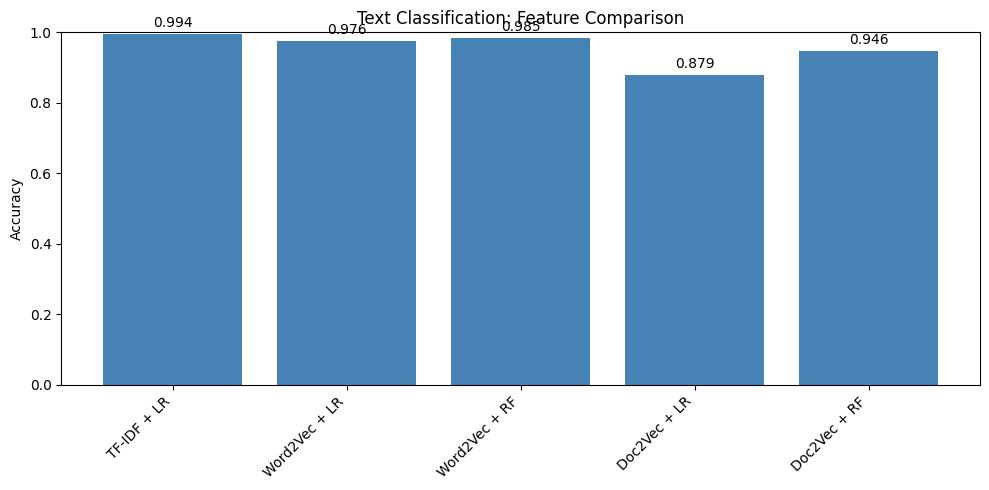

In [145]:
# Compare with TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf_vec.fit_transform(df['Article'])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# TF-IDF + Logistic Regression
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train_tfidf)
lr_tfidf_pred = lr_tfidf.predict(X_test_tfidf)
lr_tfidf_acc = accuracy_score(y_test_tfidf, lr_tfidf_pred)

print("=" * 70)
print("CLASSIFICATION COMPARISON")
print("=" * 70)

comparison = {
    'TF-IDF + LR': lr_tfidf_acc,
    'Word2Vec + LR': lr_acc,
    'Word2Vec + RF': rf_acc,
    'Doc2Vec + LR': lr_d2v_acc,
    'Doc2Vec + RF': rf_d2v_acc,
}

print(f"\n{'Method':<25} {'Accuracy':<10}")
print("-" * 40)
for method, acc in sorted(comparison.items(), key=lambda x: x[1], reverse=True):
    print(f"{method:<25} {acc:.4f}")

# Plot comparison
plt.figure(figsize=(10, 5))
plt.bar(comparison.keys(), comparison.values(), color='steelblue')
plt.ylabel('Accuracy')
plt.title('Text Classification: Feature Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for i, (method, acc) in enumerate(comparison.items()):
    plt.text(i, acc + 0.02, f'{acc:.3f}', ha='center')
plt.tight_layout()
plt.show()

#  DOCUMENT CLUSTERING

K-Means Clustering with Embeddings

DOCUMENT CLUSTERING
Number of clusters: 3
Cluster distribution: Counter({1: 1122, 2: 982, 0: 588})

Sample Documents per Cluster:

--- Cluster 0 ---
  Doc 1: asia stocks up in new year trad
  Doc 2: hong kong stocks open 0.66 percent lower
  Doc 3: asian stocks sink euro near nine year 

--- Cluster 1 ---
  Doc 0: sindh govt decides to cut public transport fares by 7pc kti rej
  Doc 13: govt may take up to ten days to overcome petrol shortag
  Doc 15: report presented to pm holds ogra responsible for fuel crisi

--- Cluster 2 ---
  Doc 1021: Amir returns to Pakistan squad after 5 year b
  Doc 1022: Australia set to test twin spin attack against Windi
  Doc 1023: Australia skipper Smith plots return to test summi


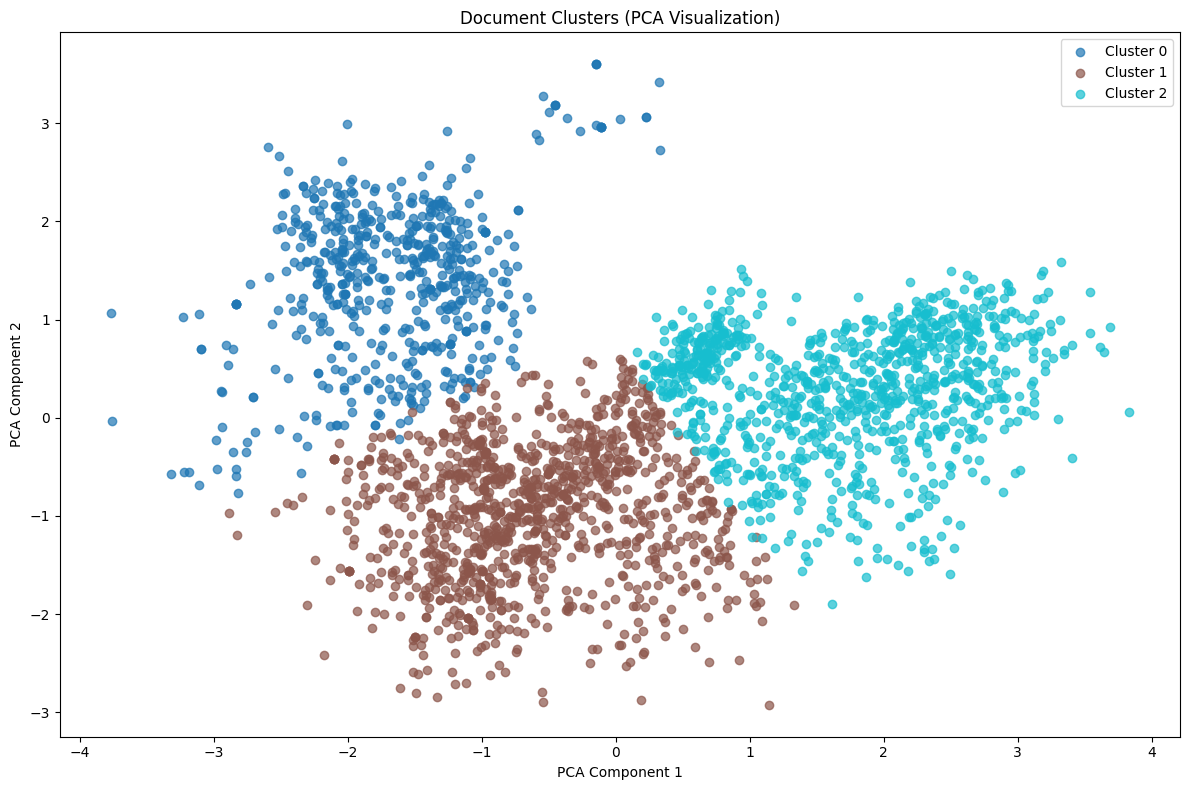

array([[-1.4144537 , -1.3666201 ],
       [-1.4930682 ,  1.5122533 ],
       [ 0.33426848,  2.7266471 ],
       ...,
       [-0.36270162, -0.826238  ],
       [-0.9503304 , -1.146126  ],
       [-0.08479916, -0.91293347]], dtype=float32)

In [146]:
class DocumentClustering:
    """Document clustering using embeddings"""
    
    def __init__(self, vectors):
        self.vectors = vectors
    
    def kmeans_clustering(self, n_clusters=5):
        """Apply K-Means clustering"""
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(self.vectors)
        return labels, kmeans
    
    def visualize_clusters(self, labels, titles, n_clusters):
        """Visualize clusters using PCA"""
        # Reduce to 2D
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(self.vectors)
        
        plt.figure(figsize=(12, 8))
        
        colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
        
        for i in range(n_clusters):
            mask = labels == i
            plt.scatter(vectors_2d[mask, 0], vectors_2d[mask, 1], 
                       c=[colors[i]], label=f'Cluster {i}', alpha=0.7)
        
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title('Document Clusters (PCA Visualization)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return vectors_2d

# Clustering with Word2Vec
clustering = DocumentClustering(X_w2v)

n_clusters = 3
labels, kmeans = clustering.kmeans_clustering(n_clusters)

print("=" * 70)
print("DOCUMENT CLUSTERING")
print("=" * 70)
print(f"Number of clusters: {n_clusters}")
print(f"Cluster distribution: {Counter(labels)}")

# Show sample documents per cluster
print("\nSample Documents per Cluster:")
for cluster_id in range(n_clusters):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_docs = np.where(labels == cluster_id)[0]
    for doc_id in cluster_docs[:3]:
        print(f"  Doc {doc_id}: {df.loc[doc_id, 'Heading']}")

# Visualize
clustering.visualize_clusters(labels, df['Heading'].tolist(), n_clusters)

# COMPLETE IR SYSTEM

Complete IR System Class

In [147]:
class CompleteIRSystem:
    """
    Complete IR System integrating all methods:
    - BM25
    - Gensim TF-IDF, LSI, LDA
    - Word2Vec, Doc2Vec
    - FAISS
    """
    
    def __init__(self, documents, preprocess_func):
        self.documents = documents
        self.preprocess_func = preprocess_func
        self.N = len(documents)
        
        print("Initializing Complete IR System...")
        
        # Preprocess corpus
        self.corpus = [preprocess_func(doc) for doc in documents]
        
        # Initialize components
        self._init_bm25()
        self._init_gensim()
        self._init_embeddings()
        self._init_faiss()
        
        print("Complete IR System ready!")
    
    def _init_bm25(self):
        """Initialize BM25"""
        self.bm25 = BM25Okapi(self.corpus)
        print("  ✓ BM25 initialized")
    
    def _init_gensim(self):
        """Initialize Gensim models"""
        self.dictionary = Dictionary(self.corpus)
        self.dictionary.filter_extremes(no_below=1, no_above=0.9)
        self.bow_corpus = [self.dictionary.doc2bow(doc) for doc in self.corpus]
        
        # TF-IDF
        self.tfidf_model = TfidfModel(self.bow_corpus)
        self.tfidf_corpus = self.tfidf_model[self.bow_corpus]
        self.tfidf_index = SparseMatrixSimilarity(self.tfidf_corpus, num_features=len(self.dictionary))
        print("  ✓ Gensim TF-IDF initialized")
        
        # LSI
        self.lsi_model = LsiModel(self.tfidf_corpus, id2word=self.dictionary, num_topics=50)
        self.lsi_corpus = self.lsi_model[self.tfidf_corpus]
        self.lsi_index = MatrixSimilarity(self.lsi_corpus)
        print("  ✓ LSI initialized")
        
        # LDA
        self.lda_model = LdaModel(self.bow_corpus, id2word=self.dictionary, num_topics=5, passes=5)
        print("  ✓ LDA initialized")
    
    def _init_embeddings(self):
        """Initialize embedding models"""
        # Word2Vec
        self.w2v_model = Word2Vec(self.corpus, vector_size=100, window=5, min_count=1, epochs=10)
        print("  ✓ Word2Vec initialized")
        
        # Document vectors
        self.doc_vectors = []
        for doc in self.corpus:
            vec = self._doc_vector(doc)
            self.doc_vectors.append(vec)
        self.doc_vectors = np.array(self.doc_vectors)
        
        # Doc2Vec
        tagged_docs = [TaggedDocument(doc, [str(i)]) for i, doc in enumerate(self.corpus)]
        self.d2v_model = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=1, epochs=10)
        print("  ✓ Doc2Vec initialized")
    
    def _init_faiss(self):
        """Initialize FAISS index"""
        vectors = self.doc_vectors.astype('float32')
        faiss.normalize_L2(vectors)
        self.faiss_index = faiss.IndexFlatIP(vectors.shape[1])
        self.faiss_index.add(vectors)
        print("  ✓ FAISS initialized")
    
    def _doc_vector(self, tokens):
        """Get document vector from Word2Vec"""
        vectors = [self.w2v_model.wv[t] for t in tokens if t in self.w2v_model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(100)
    
    def search_bm25(self, query, top_k=5):
        """BM25 search"""
        tokens = self.preprocess_func(query)
        scores = self.bm25.get_scores(tokens)
        top_idx = np.argsort(scores)[::-1][:top_k]
        return [(idx, scores[idx]) for idx in top_idx]
    
    def search_tfidf(self, query, top_k=5):
        """Gensim TF-IDF search"""
        tokens = self.preprocess_func(query)
        bow = self.dictionary.doc2bow(tokens)
        tfidf = self.tfidf_model[bow]
        sims = self.tfidf_index[tfidf]
        top_idx = np.argsort(sims)[::-1][:top_k]
        return [(idx, sims[idx]) for idx in top_idx]
    
    def search_lsi(self, query, top_k=5):
        """LSI search"""
        tokens = self.preprocess_func(query)
        bow = self.dictionary.doc2bow(tokens)
        tfidf = self.tfidf_model[bow]
        lsi = self.lsi_model[tfidf]
        sims = self.lsi_index[lsi]
        top_idx = np.argsort(sims)[::-1][:top_k]
        return [(idx, sims[idx]) for idx in top_idx]
    
    def search_w2v(self, query, top_k=5):
        """Word2Vec search"""
        tokens = self.preprocess_func(query)
        query_vec = self._doc_vector(tokens)
        
        sims = []
        for i, doc_vec in enumerate(self.doc_vectors):
            sim = np.dot(query_vec, doc_vec) / (np.linalg.norm(query_vec) * np.linalg.norm(doc_vec) + 1e-8)
            sims.append(sim)
        
        top_idx = np.argsort(sims)[::-1][:top_k]
        return [(idx, sims[idx]) for idx in top_idx]
    
    def search_faiss(self, query, top_k=5):
        """FAISS search"""
        tokens = self.preprocess_func(query)
        query_vec = self._doc_vector(tokens).astype('float32').reshape(1, -1)
        faiss.normalize_L2(query_vec)
        
        distances, indices = self.faiss_index.search(query_vec, top_k)
        return [(indices[0][i], distances[0][i]) for i in range(top_k)]
    
    def search_all(self, query, top_k=5):
        """Search using all methods"""
        return {
            'BM25': self.search_bm25(query, top_k),
            'TF-IDF': self.search_tfidf(query, top_k),
            'LSI': self.search_lsi(query, top_k),
            'Word2Vec': self.search_w2v(query, top_k),
            'FAISS': self.search_faiss(query, top_k)
        }
    
    def get_topics(self, num_words=10):
        """Get LDA topics"""
        return self.lda_model.print_topics(num_words=num_words)

# Create complete IR system
ir_system = CompleteIRSystem(df['Article'].tolist(), preprocess_with_stemming)

Initializing Complete IR System...
  ✓ BM25 initialized
  ✓ Gensim TF-IDF initialized
  ✓ LSI initialized
  ✓ LDA initialized
  ✓ Word2Vec initialized
  ✓ Doc2Vec initialized
  ✓ FAISS initialized
Complete IR System ready!


Test Complete System

In [148]:
print("=" * 80)
print("COMPLETE IR SYSTEM DEMO")
print("=" * 80)

# Test query
query = "hong kong stock market business"

print(f"\n🔍 Query: '{query}'")
print("-" * 80)

results = ir_system.search_all(query, top_k=5)

for method, res in results.items():
    print(f"\n{method}:")
    for rank, (doc_id, score) in enumerate(res[:3], 1):
        print(f"  {rank}. Doc {doc_id} ({score:.4f}): {df.loc[doc_id, 'Heading']}")

# Show LDA topics
print("\n" + "=" * 80)
print("LDA TOPICS:")
print("-" * 80)
topics = ir_system.get_topics(num_words=8)
for topic_id, topic in topics:
    print(f"Topic {topic_id}: {topic}")

COMPLETE IR SYSTEM DEMO

🔍 Query: 'hong kong stock market business'
--------------------------------------------------------------------------------

BM25:
  1. Doc 2589 (19.0561): McDonald sells China operations 208 b
  2. Doc 566 (17.0404): China Hong Kong shares firm as export growth raises hopes for GDP
  3. Doc 274 (16.5164): kse 100 plummets over 1000 points in intra day trading

TF-IDF:
  1. Doc 11 (0.5128): hong kong stocks open 0.24 percent higher
  2. Doc 67 (0.4900): hong kong stocks open 0.70 percent higher
  3. Doc 2459 (0.4106): Hong Kong stocks rise at 

LSI:
  1. Doc 11 (0.9289): hong kong stocks open 0.24 percent higher
  2. Doc 2459 (0.9207): Hong Kong stocks rise at 
  3. Doc 67 (0.9074): hong kong stocks open 0.70 percent higher

Word2Vec:
  1. Doc 84 (0.9084): stocks tumble as kse 100 share index drops 817 poi
  2. Doc 2459 (0.8910): Hong Kong stocks rise at 
  3. Doc 274 (0.8894): kse 100 plummets over 1000 points in intra day trading

FAISS:
  1. Doc 84 (0.9084):

Interactive Search Function

In [149]:
def interactive_search(query, method='all', top_k=5):
    """
    Interactive search function
    
    Methods: 'bm25', 'tfidf', 'lsi', 'w2v', 'faiss', 'all'
    """
    print("=" * 70)
    print(f"🔍 SEARCH: '{query}'")
    print(f"   Method: {method.upper()}")
    print("=" * 70)
    
    if method == 'all':
        results = ir_system.search_all(query, top_k)
        for method_name, res in results.items():
            print(f"\n📌 {method_name}:")
            for rank, (doc_id, score) in enumerate(res, 1):
                print(f"   {rank}. [{score:.4f}] {df.loc[doc_id, 'Heading']}")
    else:
        method_map = {
            'bm25': ir_system.search_bm25,
            'tfidf': ir_system.search_tfidf,
            'lsi': ir_system.search_lsi,
            'w2v': ir_system.search_w2v,
            'faiss': ir_system.search_faiss
        }
        
        if method in method_map:
            results = method_map[method](query, top_k)
            print(f"\nResults:")
            for rank, (doc_id, score) in enumerate(results, 1):
                print(f"\n   {rank}. Score: {score:.4f}")
                print(f"      Heading: {df.loc[doc_id, 'Heading']}")
                print(f"      Article: {df.loc[doc_id, 'Article'][:100]}...")

# Test interactive search
interactive_search("oil prices market", method='all', top_k=3)

🔍 SEARCH: 'oil prices market'
   Method: ALL

📌 BM25:
   1. [8.1890] US crude oil prices approach 20 pc fall since beginning of 2016
   2. [8.1030] oil prices fall as iea predicts weak rebound
   3. [8.0925] Oil prices stable as market seen bottoming but oversupply linger

📌 TF-IDF:
   1. [0.3591] Oil prices stable as market seen bottoming but oversupply linger
   2. [0.3364] Oil jumps as traders close short positions US producers cut rig cou
   3. [0.3364] Oil jumps as traders close short positions US producers cut rig cou

📌 LSI:
   1. [0.8757] oil prices fall as iea predicts weak rebound
   2. [0.8516] Oil prices dip over scepticism ahead of OPEC meeting
   3. [0.8495] Oil prices fall US drillers add rigs speculators cut long positi

📌 Word2Vec:
   1. [0.8481] oil prices fall as iea predicts weak rebound
   2. [0.8375] oil hits new 5.5 year lows as saudis defend 
   3. [0.8369] oil prices drop on weak demand potential iran d

📌 FAISS:
   1. [0.8481] oil prices fall as iea predicts w

Summary and Statistics

In [150]:
def print_summary():
    """Print comprehensive summary"""
    
    summary = """
╔══════════════════════════════════════════════════════════════════════════════╗
║     INFORMATION RETRIEVAL & TEXT MINING - IMPLEMENTATION SUMMARY             ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                               ║
║  LIBRARIES USED:                                                              ║
║  ─────────────────────────────────────────────────────────────────────────   ║
║  • Gensim      - TF-IDF, LSI, LDA, Word2Vec, Doc2Vec                         ║
║  • rank-bm25   - BM25 Okapi, BM25+, BM25L                                    ║
║  • FAISS       - Efficient similarity search                                 ║
║  • scikit-learn - Classification, clustering, evaluation                     ║
║                                                                               ║
║  RETRIEVAL MODELS IMPLEMENTED:                                               ║
║  ─────────────────────────────────────────────────────────────────────────   ║
║  1. BM25 (Okapi, Plus, L)     - Probabilistic ranking                        ║
║  2. TF-IDF (Gensim)           - Term weighting                               ║
║  3. LSI                        - Latent Semantic Indexing                    ║
║  4. Word2Vec                   - Word embeddings for retrieval               ║
║  5. Doc2Vec                    - Document embeddings                         ║
║  6. FAISS                      - Efficient vector search                     ║
║                                                                               ║
║  TEXT MINING COMPONENTS:                                                      ║
║  ─────────────────────────────────────────────────────────────────────────   ║
║  • Topic Modeling (LDA)                                                       ║
║  • Document Clustering (K-Means)                                             ║
║  • Text Classification (LR, RF with embeddings)                              ║
║  • Word Similarity (Word2Vec)                                                ║
║                                                                               ║
║  KEY FEATURES:                                                                ║
║  ─────────────────────────────────────────────────────────────────────────   ║
║  • Multiple preprocessing options (stemming, lemmatization)                  ║
║  • Comparison of retrieval methods                                           ║
║  • Visualization (clusters, topics)                                          ║
║  • Classification with different feature types                               ║
║                                                                               ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""
    print(summary)

print_summary()

# System Statistics
print("\n" + "=" * 70)
print("SYSTEM STATISTICS")
print("=" * 70)
print(f"Total Documents: {len(df)}")
print(f"Vocabulary Size (Gensim): {len(ir_system.dictionary)}")
print(f"Word2Vec Vocabulary: {len(ir_system.w2v_model.wv)}")
print(f"Document Vector Dimension: {ir_system.doc_vectors.shape[1]}")
print(f"FAISS Index Size: {ir_system.faiss_index.ntotal}")
print(f"LDA Topics: {ir_system.lda_model.num_topics}")
print(f"LSI Topics: {ir_system.lsi_model.num_topics}")


╔══════════════════════════════════════════════════════════════════════════════╗
║     INFORMATION RETRIEVAL & TEXT MINING - IMPLEMENTATION SUMMARY             ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                               ║
║  LIBRARIES USED:                                                              ║
║  ─────────────────────────────────────────────────────────────────────────   ║
║  • Gensim      - TF-IDF, LSI, LDA, Word2Vec, Doc2Vec                         ║
║  • rank-bm25   - BM25 Okapi, BM25+, BM25L                                    ║
║  • FAISS       - Efficient similarity search                                 ║
║  • scikit-learn - Classification, clustering, evaluation                     ║
║                                                                               ║
║  RETRIEVAL MODELS IMPLEMENTED:                                               ║
║  ─────────────────────

Final Comparison Table

In [151]:
def final_comparison(queries, df, top_k=3):
    """Final comparison of all methods"""
    
    print("=" * 100)
    print("FINAL COMPARISON OF ALL RETRIEVAL METHODS")
    print("=" * 100)
    
    for query in queries:
        print(f"\n{'─' * 100}")
        print(f"Query: '{query}'")
        print(f"{'─' * 100}")
        
        results = ir_system.search_all(query, top_k)
        
        # Header
        print(f"\n{'Rank':<6}", end="")
        for method in results.keys():
            print(f"{method:<18}", end="")
        print()
        print("-" * 100)
        
        # Results
        for i in range(top_k):
            print(f"{i+1:<6}", end="")
            for method, res in results.items():
                doc_id, score = res[i]
                print(f"Doc {doc_id} ({score:.2f})   ", end="")
            print()
        
        # Show headings for top result
        print(f"\nTop Results Details:")
        seen = set()
        for method, res in results.items():
            doc_id = res[0][0]
            if doc_id not in seen:
                print(f"  Doc {doc_id}: {df.loc[doc_id, 'Heading']}")
                seen.add(doc_id)

# Run final comparison
test_queries = [
    "hong kong stock market",
    "oil prices economy",
    "asian business growth"
]

final_comparison(test_queries, df)

FINAL COMPARISON OF ALL RETRIEVAL METHODS

────────────────────────────────────────────────────────────────────────────────────────────────────
Query: 'hong kong stock market'
────────────────────────────────────────────────────────────────────────────────────────────────────

Rank  BM25              TF-IDF            LSI               Word2Vec          FAISS             
----------------------------------------------------------------------------------------------------
1     Doc 566 (17.04)   Doc 11 (0.57)   Doc 11 (0.94)   Doc 2459 (0.91)   Doc 2459 (0.91)   
2     Doc 274 (16.52)   Doc 67 (0.54)   Doc 2459 (0.93)   Doc 84 (0.89)   Doc 84 (0.89)   
3     Doc 2459 (16.50)   Doc 2459 (0.45)   Doc 67 (0.92)   Doc 11 (0.89)   Doc 11 (0.89)   

Top Results Details:
  Doc 566: China Hong Kong shares firm as export growth raises hopes for GDP
  Doc 11: hong kong stocks open 0.24 percent higher
  Doc 2459: Hong Kong stocks rise at 

──────────────────────────────────────────────────────────